# Time Series Analysis

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Covert the featured label into a discrete column value type, instead of continuous.
* Time Shift the provided datasets with varied 'lag' values.
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set.
* Perform feature selection on the agglomorated matrix, dropping redundant features and finding the  optimum number of features. (Multivariate analysis - through a wrapper approach)
* Feed dataset into a number of machine learning models

Applicable links:
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Module Installation and Importing Libraries

https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

In [33]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math

scipy: 1.1.0
numpy: 1.15.2
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.20.0
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment

This cell also contains the network structure.

https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

In [34]:
#
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=1 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
test_split=.2 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA'] # Denotes which label to use for time series experiments
#
# Forest Config
parallel_degree = 10
n_estimators = 100
#
# LSTM Network Structure eg: 
#Layers -> [Input, Hidden, Hidden, Output]
batch_size=10

### Read data from file into pandas dataframes

In [35]:
#
# Open Data
# rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
# rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
# rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
rep_hist_snapshot_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Pivoting tables and changing matrix shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [36]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)
#
print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))
#
# print(rep_hist_snapshot_df.groupby(['SNAP_ID']).count())
# print(rep_hist_sysmetric_summary_df.groupby(['SNAP_ID']).count())
# print(rep_hist_sysstat_df.groupby(['SNAP_ID']).count())
# print(len(rep_hist_snapshot_df['SNAP_ID'].unique()))
# print(len(rep_hist_sysmetric_summary_df['SNAP_ID'].unique()))
# print(len(rep_hist_sysstat_df['SNAP_ID'].unique()))
# print(rep_hist_sysmetric_summary_df.tail())
# print(rep_hist_sysstat_df.tail())

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (19500, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (19500, 163)
Table [REP_HIST_SYSSTAT] - (19501, 1180)


### Dealing with empty values

In [37]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND TIME PER SEC', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'CURRENT OS LOAD', 'DDL STATEMENTS PARALLELIZED PER SEC', 'DML STATEMENTS PARALLELIZED PER SEC', 'HOST CPU USAGE PER SEC', 'I/O MEGABYTES PER SECOND', 'I/O REQUESTS PER SECOND', 'LOGICAL READS PER USER CALL', 'PQ QC SESSION COUNT', 'PQ SLAVE SESSION COUNT', 'PX OPERATIONS NOT DOWNGRADED PER SEC', 'QUERIES PARALLELIZED PER SEC', 'REPLAYED USER CALLS', 'RUN QUEUE PER SEC', 'SESSION COUNT', 'STREAMS POOL USAGE PERCENTAGE', 'TEMP SPACE USED', 'TOTAL PGA ALLOCATED', 'TOTAL PGA USED BY SQL WORKAREAS', 'TOTAL SORTS PER USER CALL', 'TOTAL TABLE SCANS PER USER CALL', 'VM IN BYTES PER SEC', 'VM OUT BYTES PER SEC', 'WORKLOAD CAPTURE AND REPLAY STATUS']

REP_HI

### Merging frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [38]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df, on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df, on ='SNAP_ID')
print(df.shape)

(19500, 1418)


### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [39]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)

### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [40]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp

### Feature Selection

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [41]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
print('Before')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter')
print(df.shape)

Before
(19500, 1418)

Shape before changes: [(19500, 1418)]
Shape after changes: [(19500, 526)]
Dropped a total [892]

After
(19500, 526)

After
(19500, 520)


## Visualizing Labels

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Histograms

A simple and commonly used plot to quickly check the distribution of a sample of data is the histogram.

In the histogram, the data is divided into a pre-specified number of groups called bins. The data is then sorted into each bin and the count of the number of observations in each bin is retained.

The plot shows the bins across the x-axis maintaining their ordinal relationship, and the count in each bin on the y-axis.

A sample of data has a Gaussian distribution of the histogram plot, showing the familiar bell shape.

### Quantile-Quantile Plot

Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

### Shapiro-Wilk Test

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

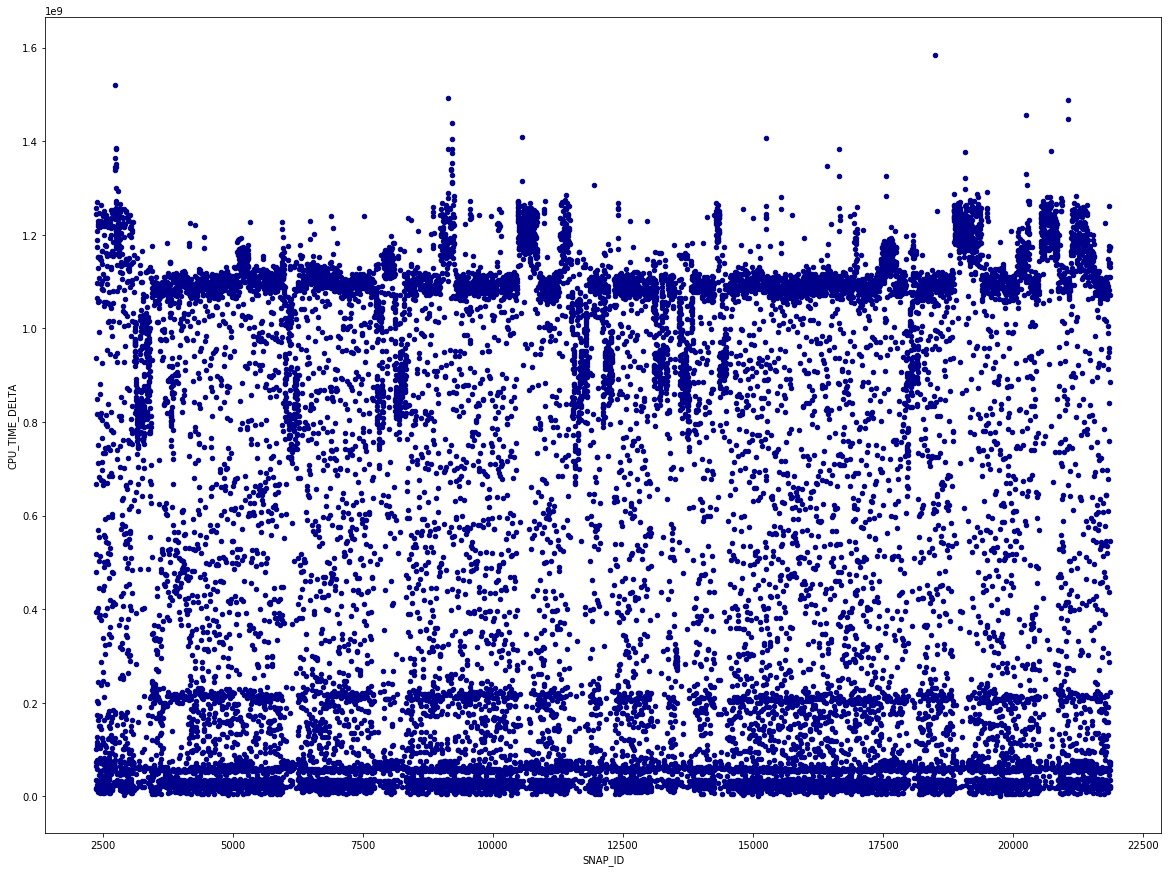

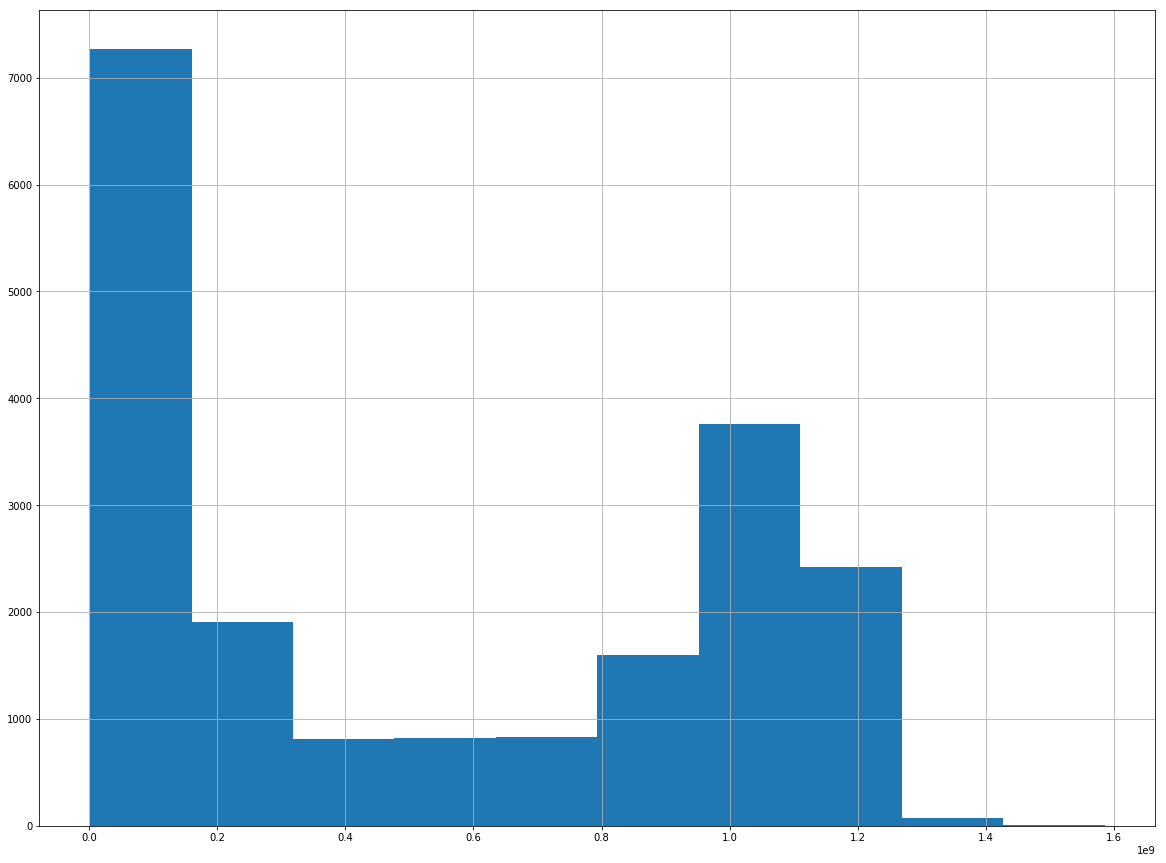

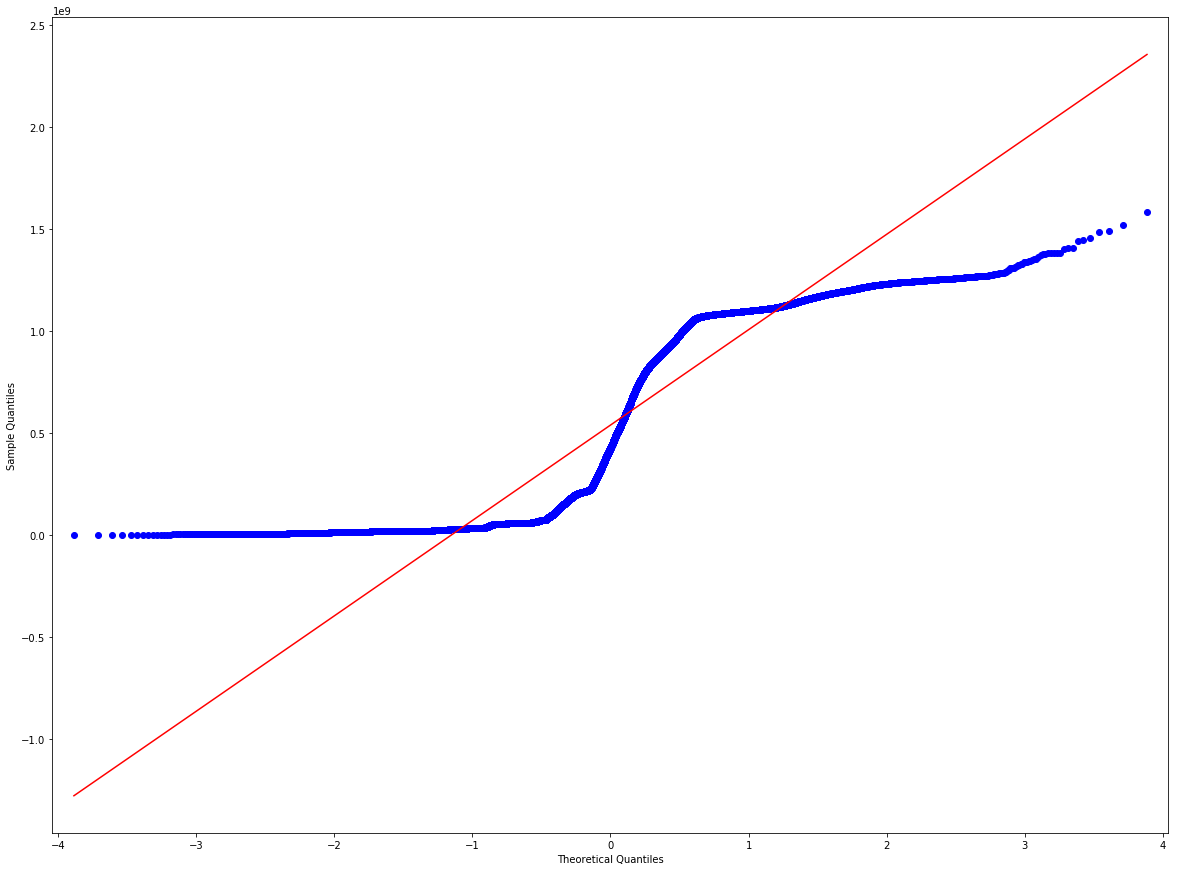

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.828, p=0.000
Sample does not look Gaussian (reject H0)


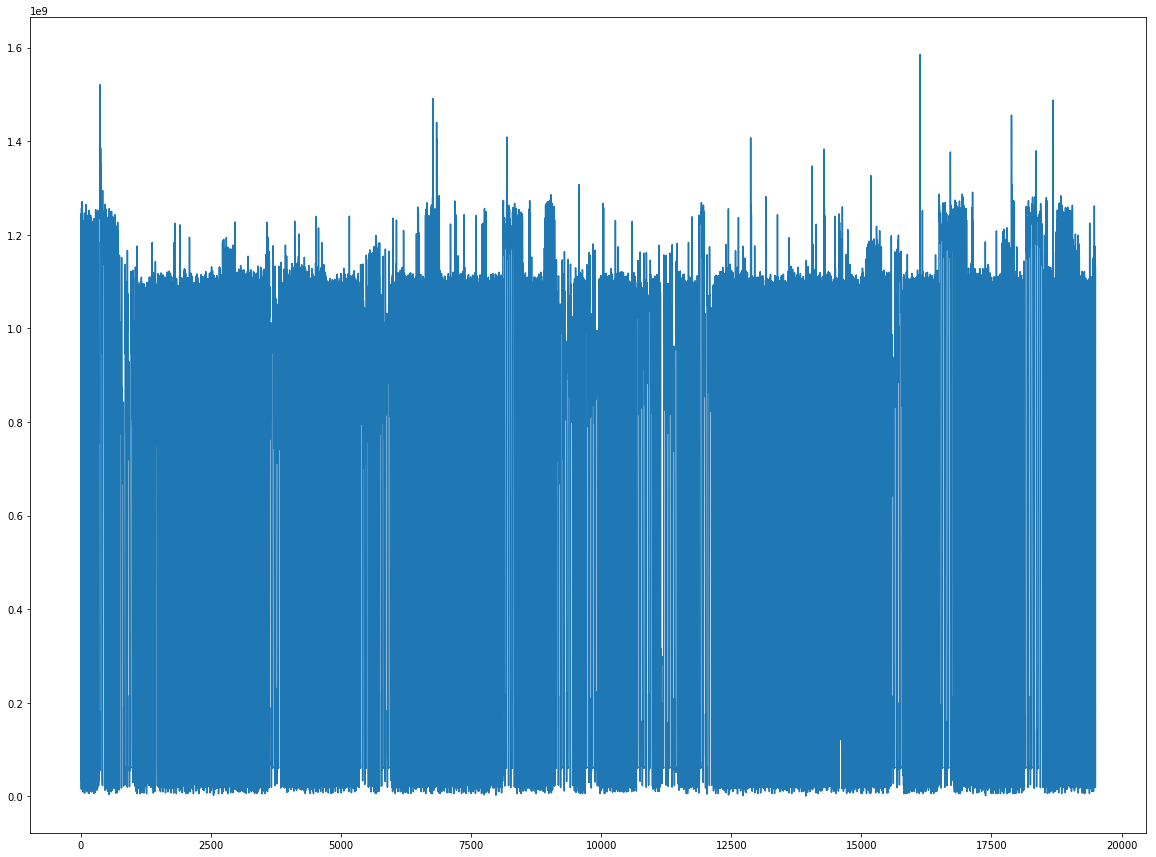

---------------------------------------------------------------


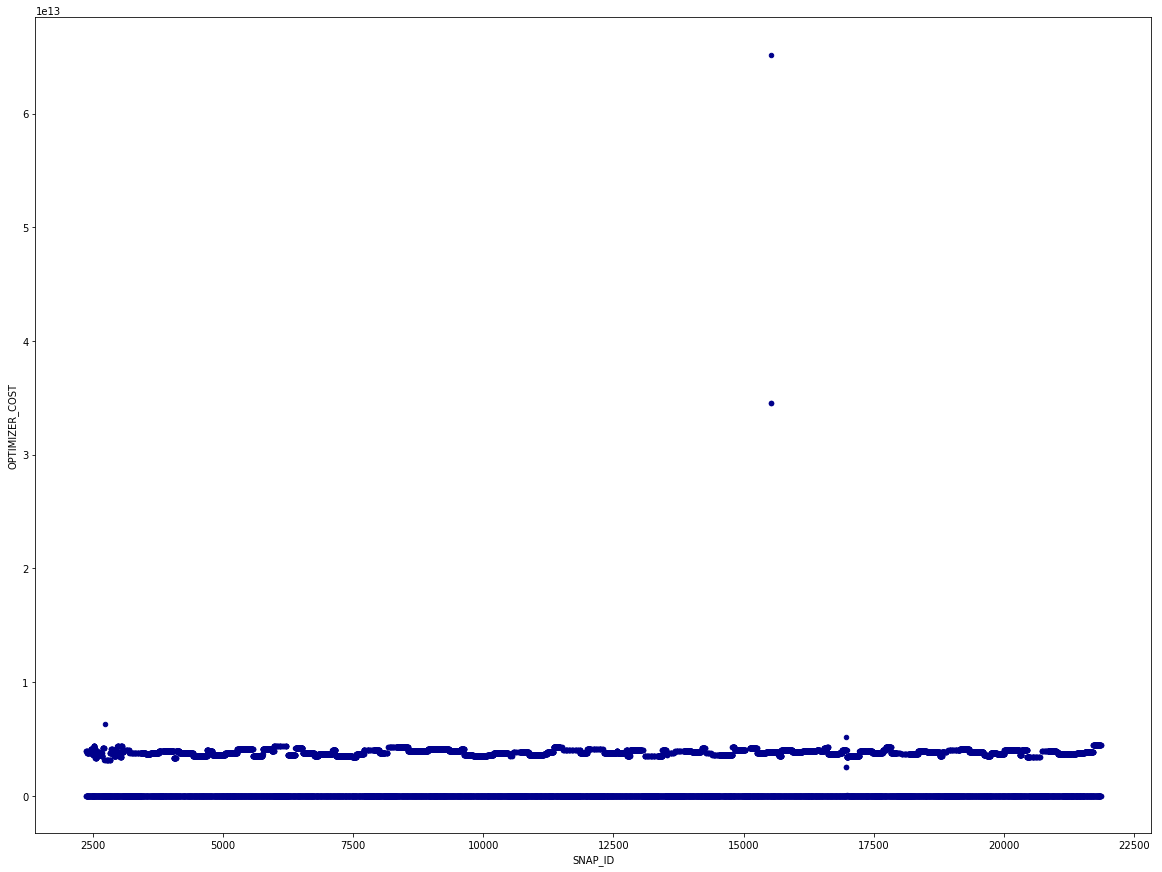

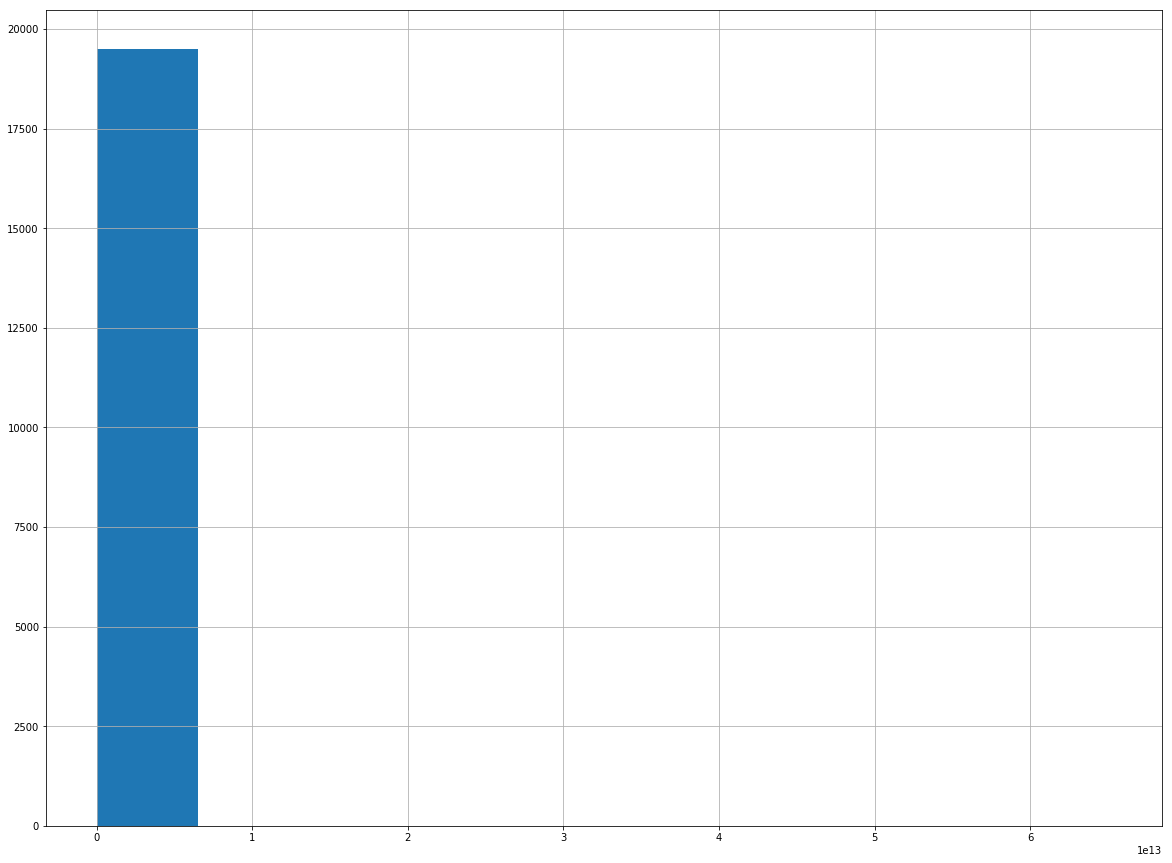

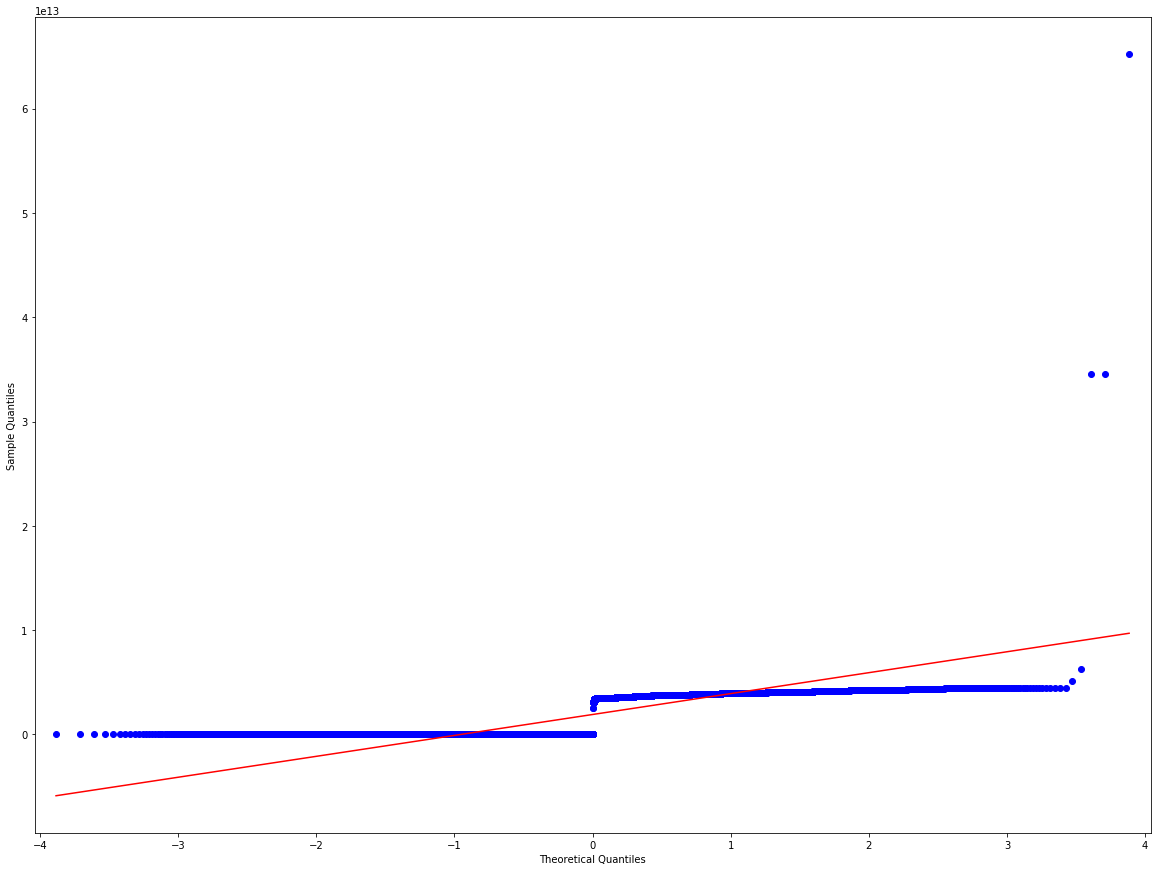

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.655, p=0.000
Sample does not look Gaussian (reject H0)


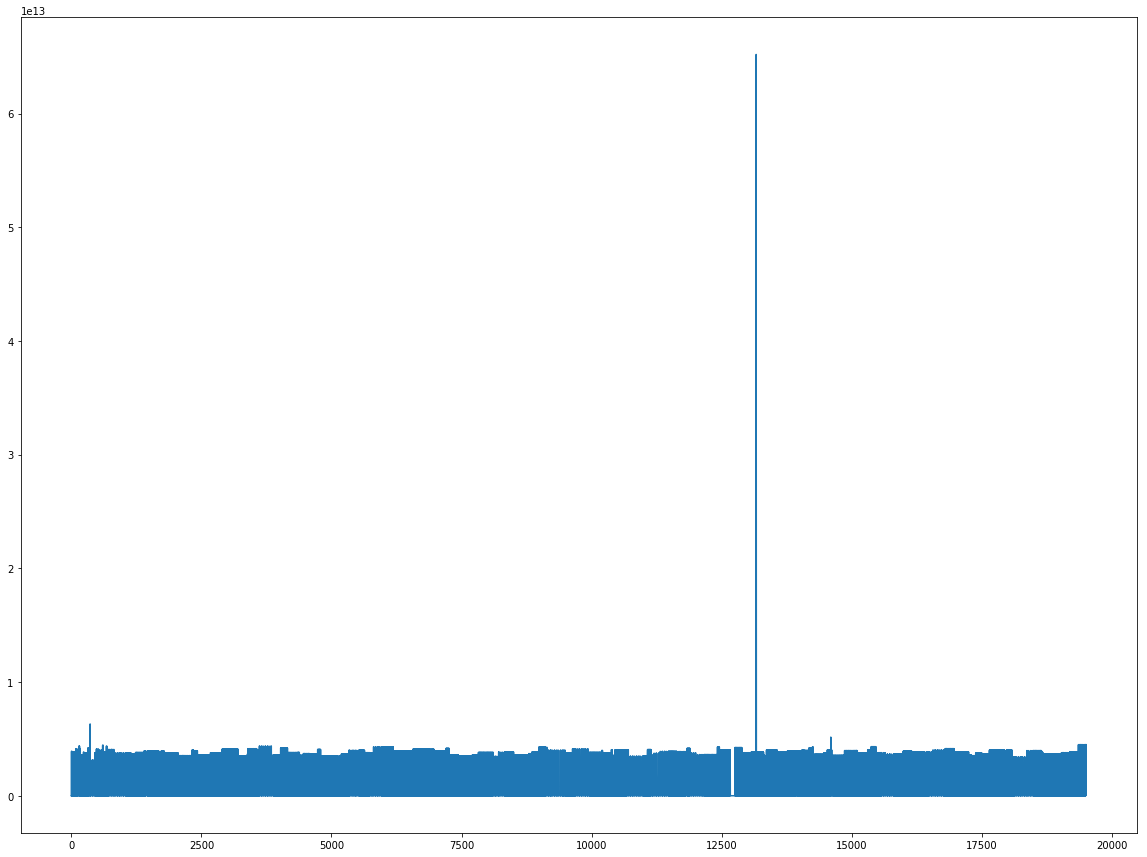

---------------------------------------------------------------


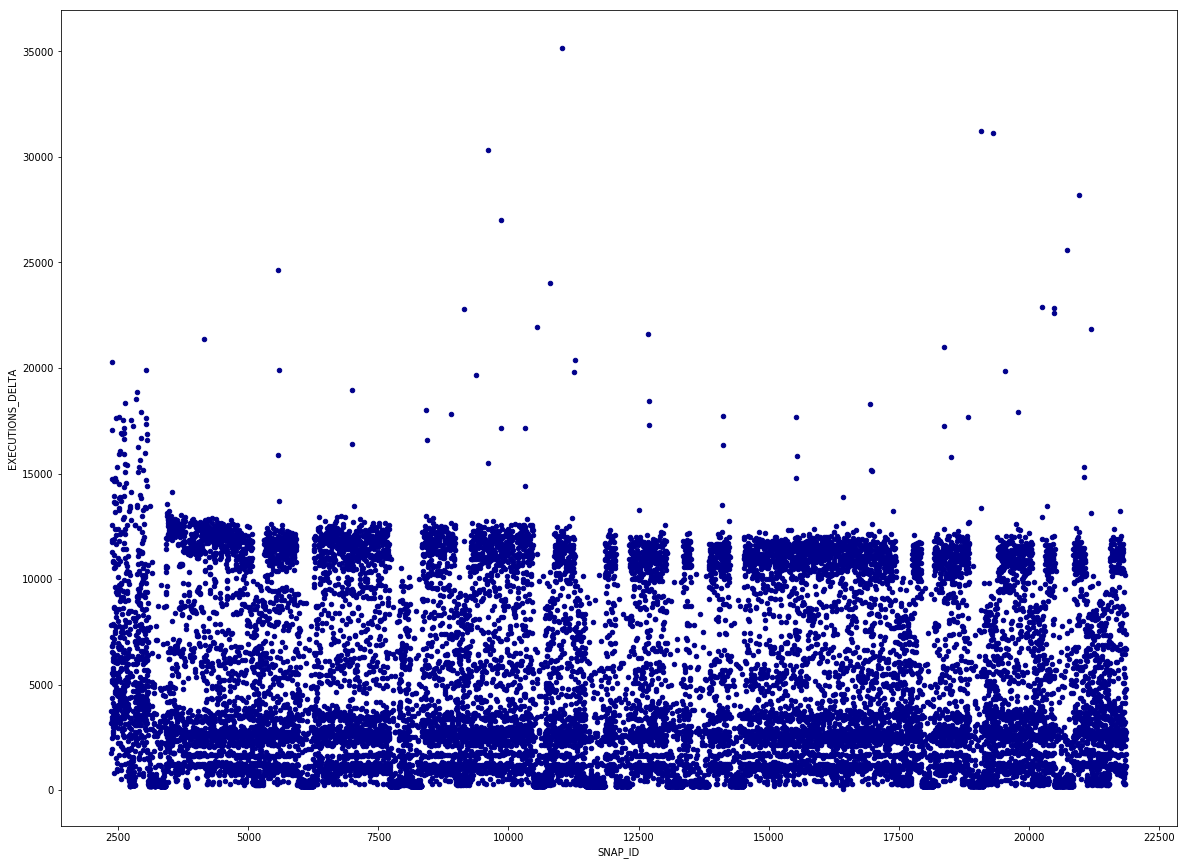

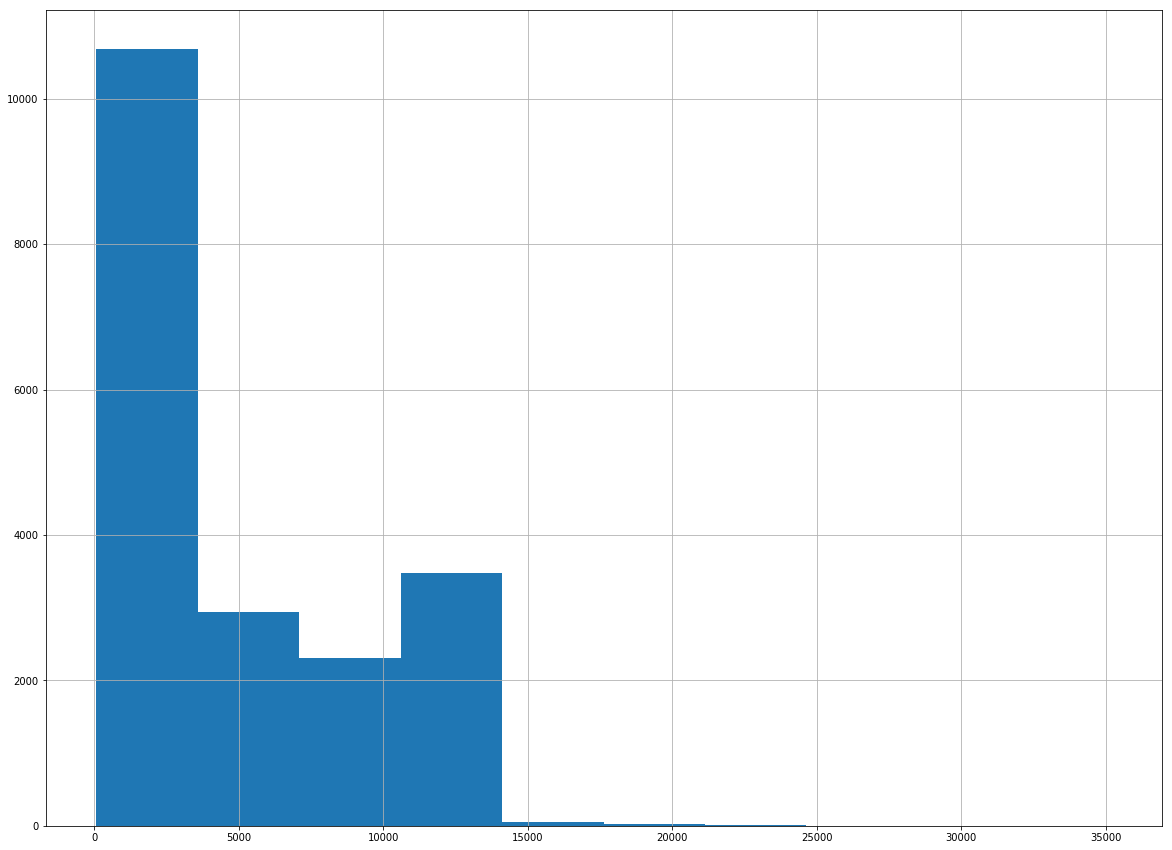

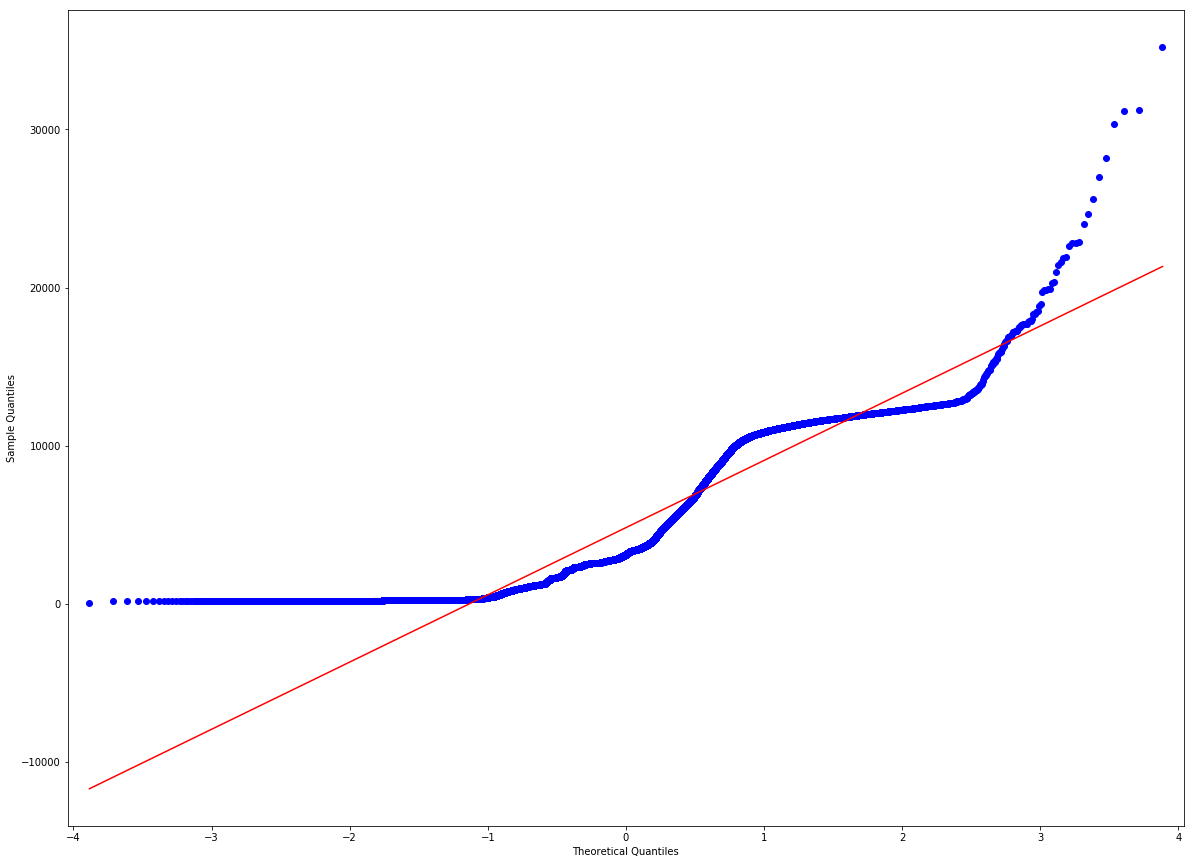

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.870, p=0.000
Sample does not look Gaussian (reject H0)


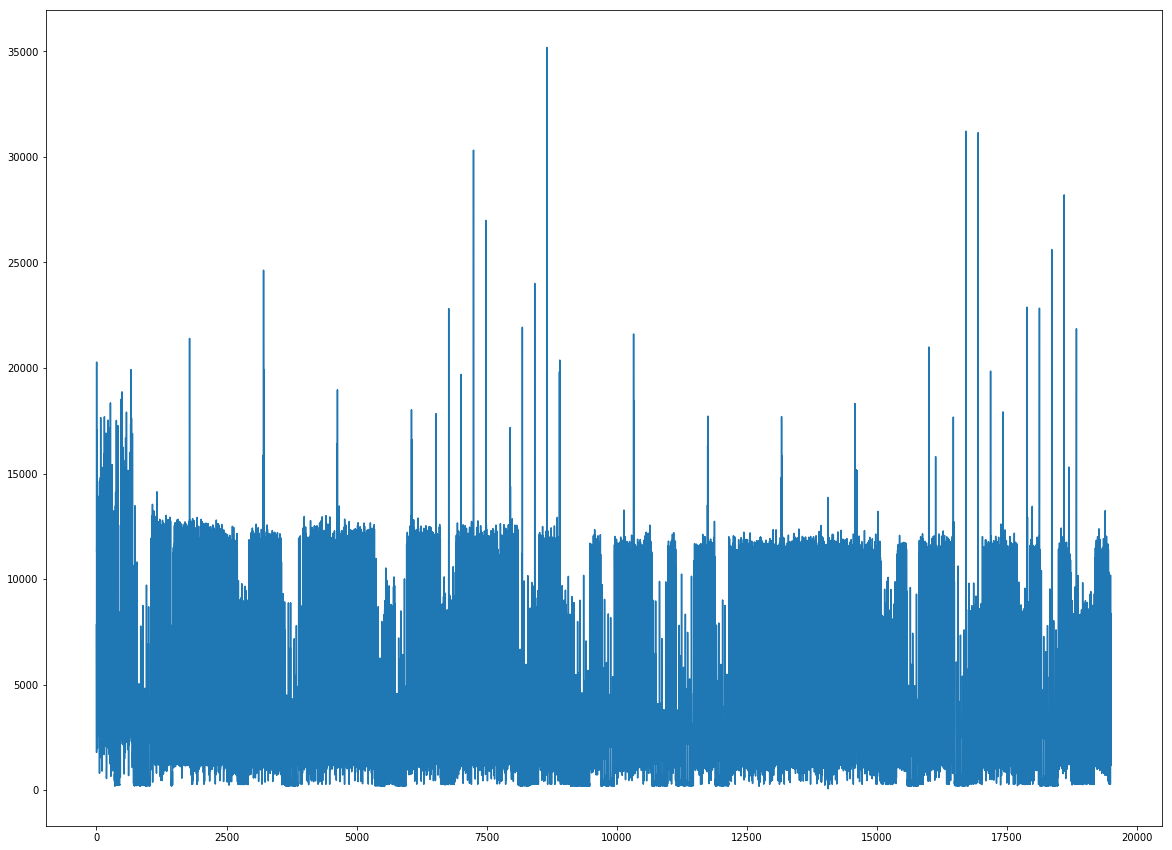

---------------------------------------------------------------


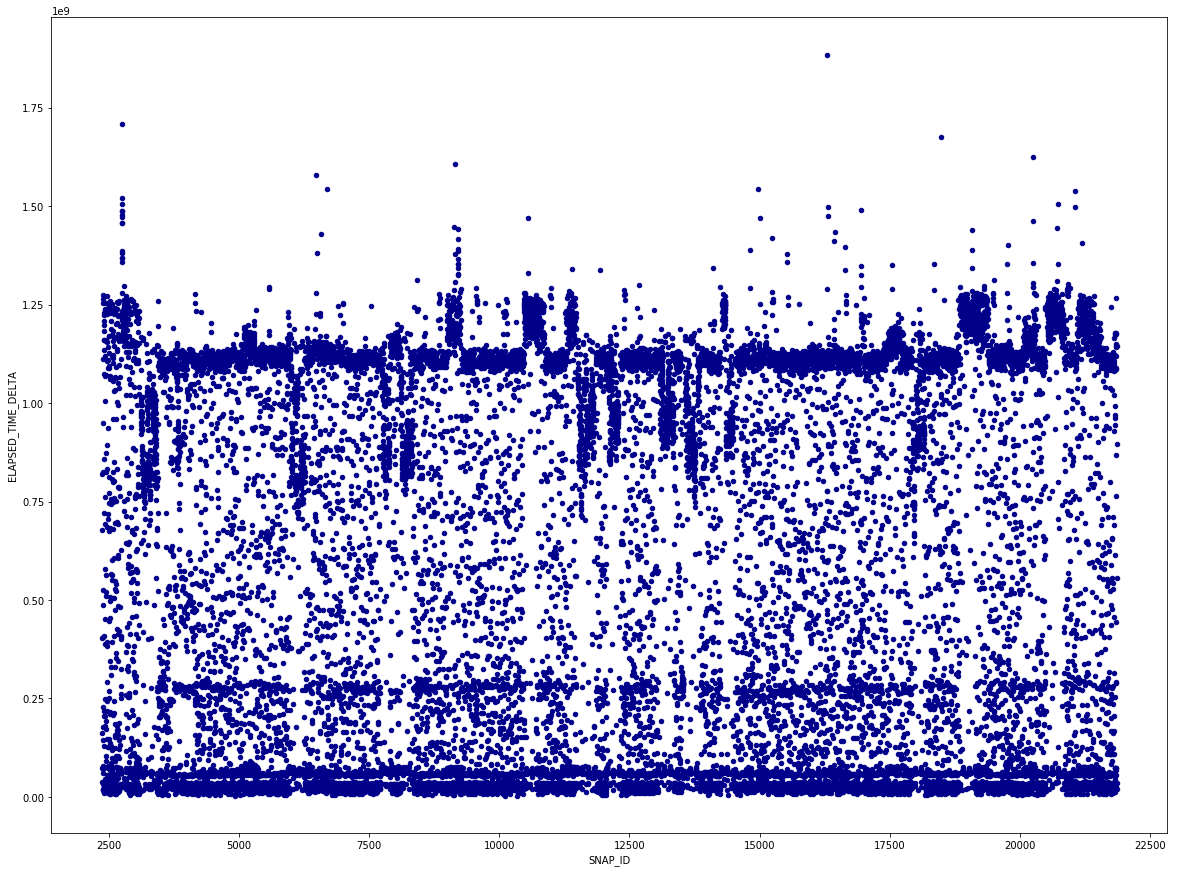

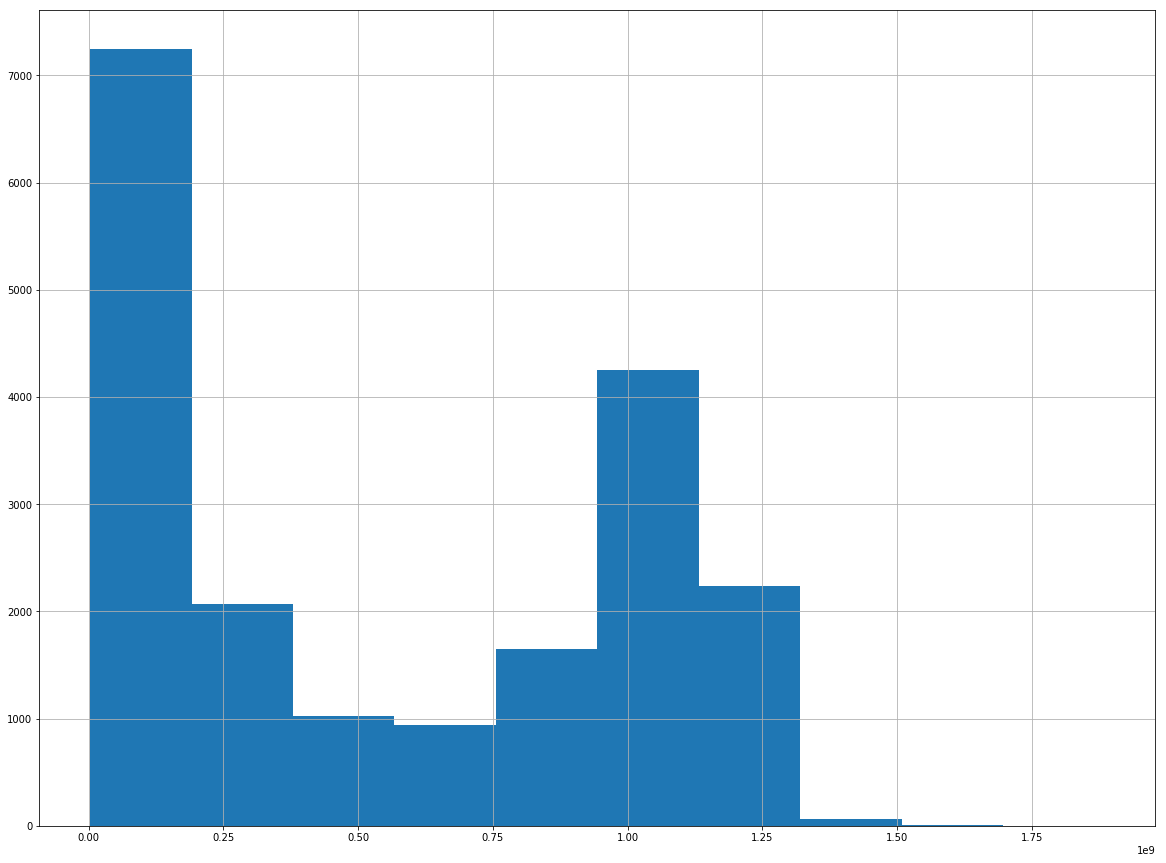

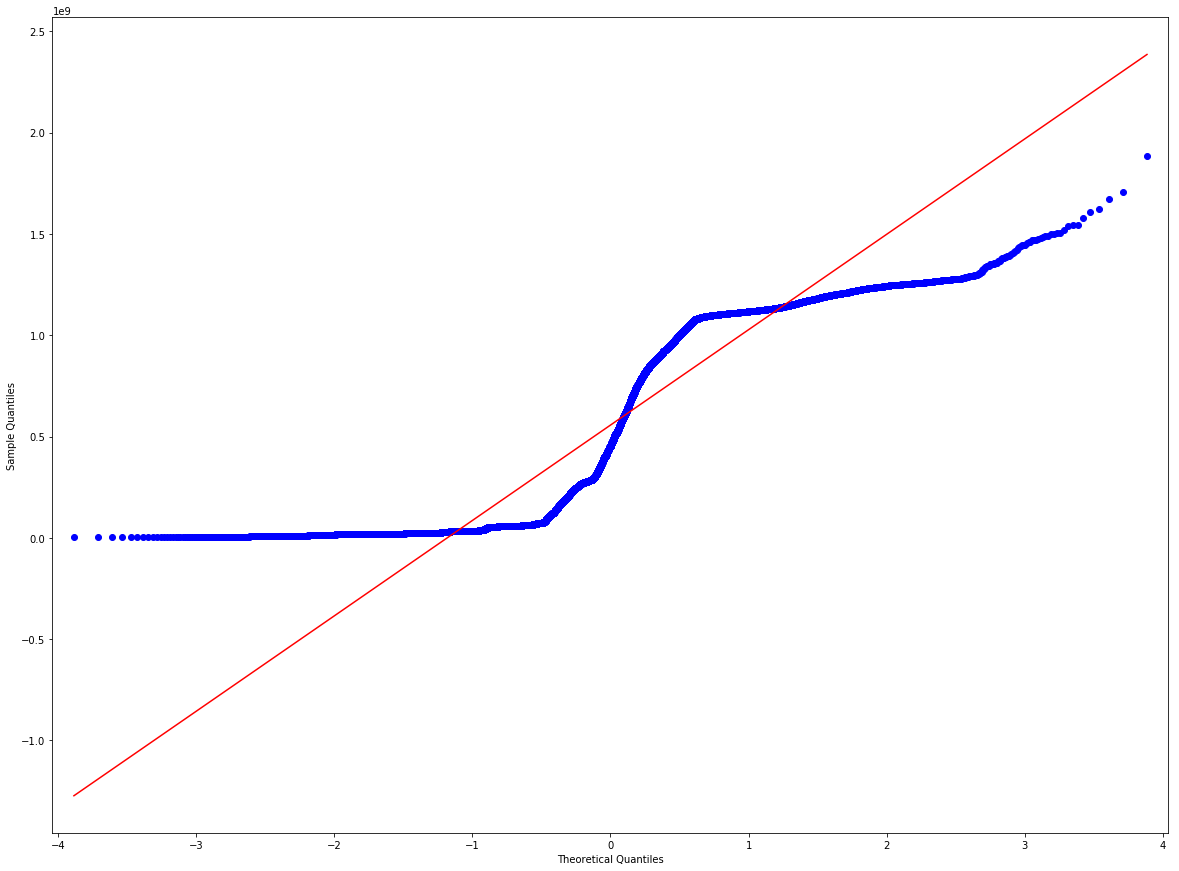

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.837, p=0.000
Sample does not look Gaussian (reject H0)


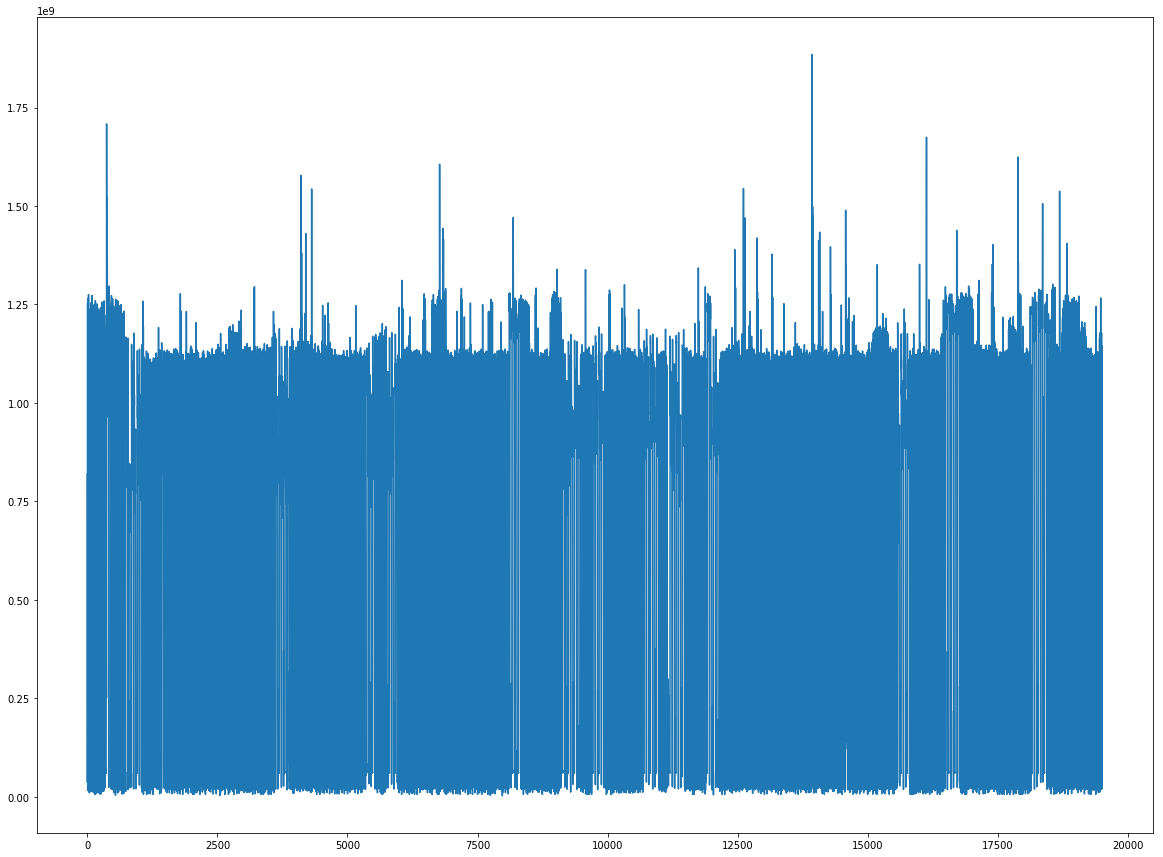

---------------------------------------------------------------


In [42]:
def shapiro_wilk(data):
    # normality test
    stat, p = sc.stats.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
#
for label in y_label:
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.show()
    df[label].hist(bins=10)
    plt.show()
    qqplot(df[label], line='s')
    plt.show()
    shapiro_wilk(data=df[label])
    plt.show()
    df[label].plot.line()
    plt.show()
    print('---------------------------------------------------------------')

### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [43]:
def get_outliers_std(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            # calculate summary statistics
            data_mean, data_std = df[header].mean(), df[header].std()
            # identify outliers
            cut_off = data_std * 3
            lower, upper = data_mean - cut_off, data_mean + cut_off
            #
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            #
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    #
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows
#
#Printing outliers to screen
outliers = get_outliers_std(df=df,
                            headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [3] outliers
EXECUTIONS_DELTA - [41] outliers
ELAPSED_TIME_DELTA - [0] outliers
Total Outliers: [44]

Label[CPU_TIME_DELTA] - Min[1355177] - Max[1585386919] - Mean[540047426.4325129] - Std[467512910.8408657]
Label[OPTIMIZER_COST] - Min[1434.0] - Max[65195559198748.0] - Mean[1915807281698.3015] - Std[2005059838683.706]
Label[EXECUTIONS_DELTA] - Min[67.0] - Max[35182.0] - Mean[4823.6879487179485] - Std[4250.089228883072]
Label[ELAPSED_TIME_DELTA] - Min[2748372] - Max[1884770068] - Mean[556542755.0932821] - Std[470937257.7591338]

---------------------------------------------

Header [OPTIMIZER_COST] - Location [13162] - Value [34513540975130.0]
Header [OPTIMIZER_COST] - Location [13163] - Value [65195559198748.0]
Header [OPTIMIZER_COST] - Location [13164] - Value [34513541170039.0]
Header [EXECUTIONS_DELTA] - Location [4] - Value [20277.0]
Header [EXECUTIONS_DELTA] - Location [82] - Value [17647.0]
Header [EXECUTIONS_DELTA] - Location [153] 

### Outlier Detection - Interquartile Range Method

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution.

A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

Remember that percentiles can be calculated by sorting the observations and selecting values at specific indices. The 50th percentile is the middle value, or the average of the two middle values for an even number of examples. If we had 10,000 samples, then the 50th percentile would be the average of the 5000th and 5001st values.

We refer to the percentiles as quartiles (“quart” meaning 4) because the data is divided into four groups via the 25th, 50th and 75th values.

The IQR defines the middle 50% of the data, or the body of the data.

The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.

In [44]:
def get_outliers_quartile(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            q25, q75 = np.percentile(df[header], 25), np.percentile(df[header], 75)
            iqr = q75 - q25
            cut_off = iqr * .6 # This values needs to remain as it. It was found to be a good value so as to capture the relavent outlier data
            lower, upper = q25 - cut_off, q75 + cut_off
            #
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            #
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    #
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows
#
#Printing outliers to screen
outliers = get_outliers_quartile(df=df,
                                 headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [4] outliers
EXECUTIONS_DELTA - [116] outliers
ELAPSED_TIME_DELTA - [1] outliers
Total Outliers: [121]

Label[CPU_TIME_DELTA] - Min[1355177] - Max[1585386919] - Mean[540047426.4325129] - Std[467512910.8408657]
Label[OPTIMIZER_COST] - Min[1434.0] - Max[65195559198748.0] - Mean[1915807281698.3015] - Std[2005059838683.706]
Label[EXECUTIONS_DELTA] - Min[67.0] - Max[35182.0] - Mean[4823.6879487179485] - Std[4250.089228883072]
Label[ELAPSED_TIME_DELTA] - Min[2748372] - Max[1884770068] - Mean[556542755.0932821] - Std[470937257.7591338]

---------------------------------------------

Header [OPTIMIZER_COST] - Location [362] - Value [6312330595825.0]
Header [OPTIMIZER_COST] - Location [13162] - Value [34513540975130.0]
Header [OPTIMIZER_COST] - Location [13163] - Value [65195559198748.0]
Header [OPTIMIZER_COST] - Location [13164] - Value [34513541170039.0]
Header [EXECUTIONS_DELTA] - Location [4] - Value [20277.0]
Header [EXECUTIONS_DELTA] - Locati

In [45]:
def edit_outliers(df=None, headers=None):
    """
    This method uses the interquartile method to edit all outliers to std.
    """
    outliers = get_outliers_quartile(df=df,
                                     headers=y_label)
    for label in y_label:
        min_val = df[label].min()
        max_val = df[label].max()
        mean_val = df[label].mean()
        std_val = df[label].std()
        #
        for i in range(len(outliers)):
            if label == outliers[i][0]:
                df[label].iloc[outliers[i][1]] = mean_val + std_val
                # print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
    return df
#
print("DF with outliers: " + str(df.shape))
df = edit_outliers(df=df,
                   headers=y_label)
print("DF with edited outliers: " + str(df.shape))

DF with outliers: (19500, 520)
CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [4] outliers
EXECUTIONS_DELTA - [116] outliers
ELAPSED_TIME_DELTA - [1] outliers


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


DF with edited outliers: (19500, 520)


### Data Normalization

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized_values = scaler.fit_transform(df.values)
#
df = pd.DataFrame(data=df_normalized_values, columns=df.columns)
del df_normalized_values
print(str(df.shape))
print(df.head())

(19500, 520)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000    1.425422e-09      0.011067       0.005771       0.093941   
1  0.000051    8.915383e-08      0.006801       0.006086       0.041094   
2  0.000103    7.567001e-01      0.007501       0.008615       0.043483   
3  0.000154    1.806442e-07      0.010642       0.008531       0.029171   
4  0.000205    7.567004e-01      0.032592       0.006877       0.366294   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.005879                  0.400300     0.004664   
1                  0.006534                  0.191255     0.008919   
2                  0.009269                  0.163413     0.015758   
3                  0.009109                  0.090977     0.011436   
4                  0.008237                  1.000000     0.008973   

   SORTS_DELTA  EXECUTIONS_TOTAL                 ...                  \
0     0.615434          0.005318           

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [47]:
y_label.append('SNAP_ID')
y_df = df[y_label]
del y_label[-1]
df.drop(columns=y_label, inplace=True)
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(df.shape))
#
# Merging labels and features in respective order
df = pd.merge(y_df,df,on='SNAP_ID',sort=False,left_on=None, right_on=None)
print('Merged Labels + Vectors: ' + str(df.shape))
print(df.head())

Label ['CPU_TIME_DELTA', 'OPTIMIZER_COST', 'EXECUTIONS_DELTA', 'ELAPSED_TIME_DELTA'] shape: (19500, 5)
Feature matrix shape: (19500, 516)
Merged Labels + Vectors: (19500, 520)
   CPU_TIME_DELTA  OPTIMIZER_COST  EXECUTIONS_DELTA  ELAPSED_TIME_DELTA  \
0        0.063258    1.425422e-09          0.583878            0.478767   
1        0.040021    8.915383e-08          0.275562            0.092982   
2        0.021644    7.567001e-01          0.232740            0.020115   
3        0.045747    1.806442e-07          0.128991            0.041988   
4        0.420241    7.567004e-01          0.676642            0.395590   

    SNAP_ID  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000      0.011067       0.005771       0.093941   
1  0.000051      0.006801       0.006086       0.041094   
2  0.000103      0.007501       0.008615       0.043483   
3  0.000154      0.010642       0.008531       0.029171   
4  0.000205      0.032592       0.006877       0.366294   

   END_OF_FETCH_CO

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

In [48]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
def remove_n_time_steps(data, n_in=1):
    if n_in == 0:
        return df
    df = data
    headers = df.columns
    dropped_headers = []
    for header in headers:
        if "(t)" in header:
            dropped_headers.append(header)
    #
    for i in range(1,n_in):
        for header in headers:
            if "(t-"+str(i)+")" in header:
                dropped_headers.append(str(header))
    #
    return df.drop(dropped_headers, axis=1)        
#
# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, 1)
#
# Seperate labels from features
y_df_column_names = shifted_df.columns[len(df.columns):len(df.columns) + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df.drop(columns=y_df_column_names)
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nVectors')
print(y_df.columns)
print(y_df.shape)
#
# Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n_in=lag)
print('\n-------------\nFeatures After Time Shift')
print(X_df.columns)
print(X_df.shape)


-------------
Features
Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       ...
       'var511(t)', 'var512(t)', 'var513(t)', 'var514(t)', 'var515(t)',
       'var516(t)', 'var517(t)', 'var518(t)', 'var519(t)', 'var520(t)'],
      dtype='object', length=1036)
(19499, 1036)

-------------
Vectors
Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'], dtype='object')
(19499, 4)

-------------
Features After Time Shift
Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       ...
       'var511(t-1)', 'var512(t-1)', 'var513(t-1)', 'var514(t-1)',
       'var515(t-1)', 'var516(t-1)', 'var517(t-1)', 'var518(t-1)',
       'var519(t-1)', 'var520(t-1)'],
      dtype='object', length=520)
(19499, 520)


### Bucket Function

Takes a value and converts it into a bucket value (of 10 values)

In [49]:
def discretize_value(amount):
    """
    Assumes that amount is decimal value. If so, return 1st value after decimal.
    """
    amount = float(amount)
    if amount < 0:
        amount = 0.01
    if amount > 1:
        amount = 0.99
    amount = str(amount)
    amount = amount.split('.')
    amount = amount[1][0]
    return float(amount)
#print(discretize_value(amount=0.26))

### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(15599, 520)] Type - <class 'numpy.ndarray'>
y_train shape [(15599, 4)] Type - <class 'numpy.ndarray'>
X_validate shape [(1950, 520)] Type - <class 'numpy.ndarray'>
y_validate shape [(1950, 4)] Type - <class 'numpy.ndarray'>
X_test shape [(1950, 520)] Type - <class 'numpy.ndarray'>
y_test shape [(1950, 4)] Type - <class 'numpy.ndarray'>


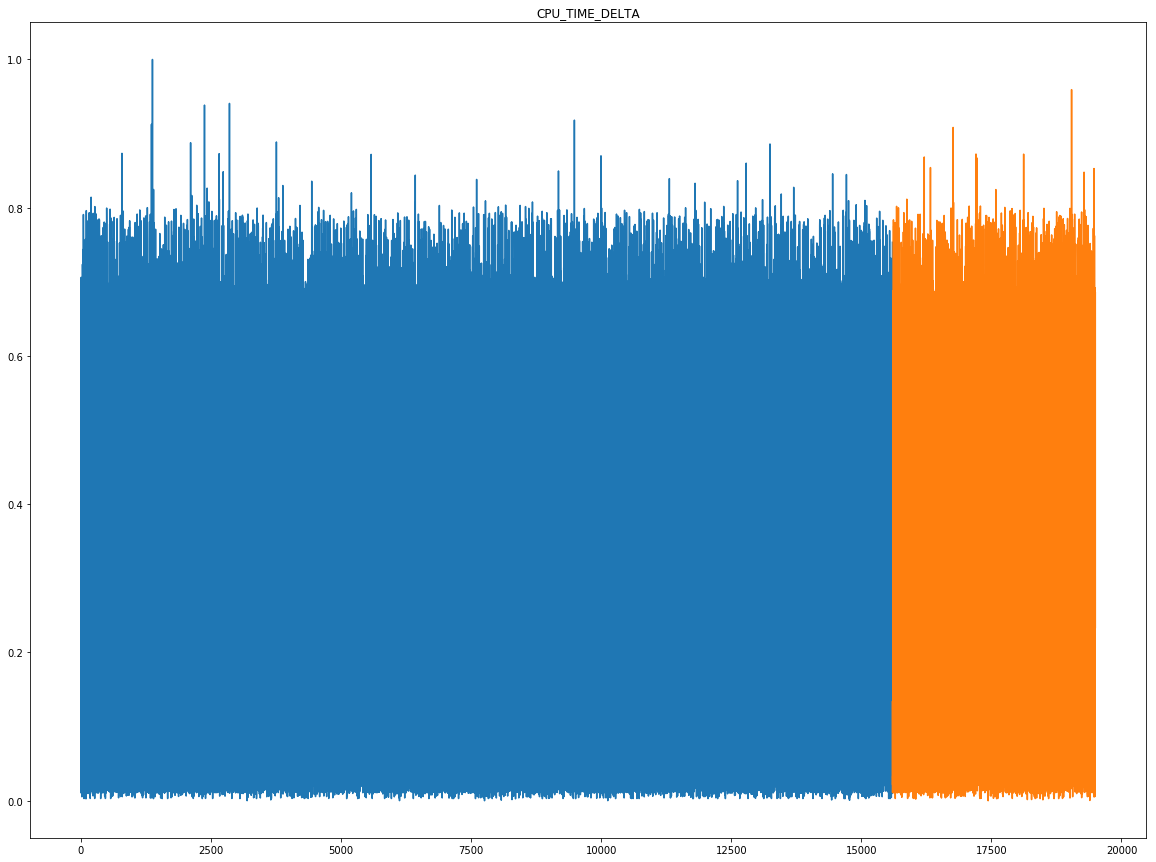

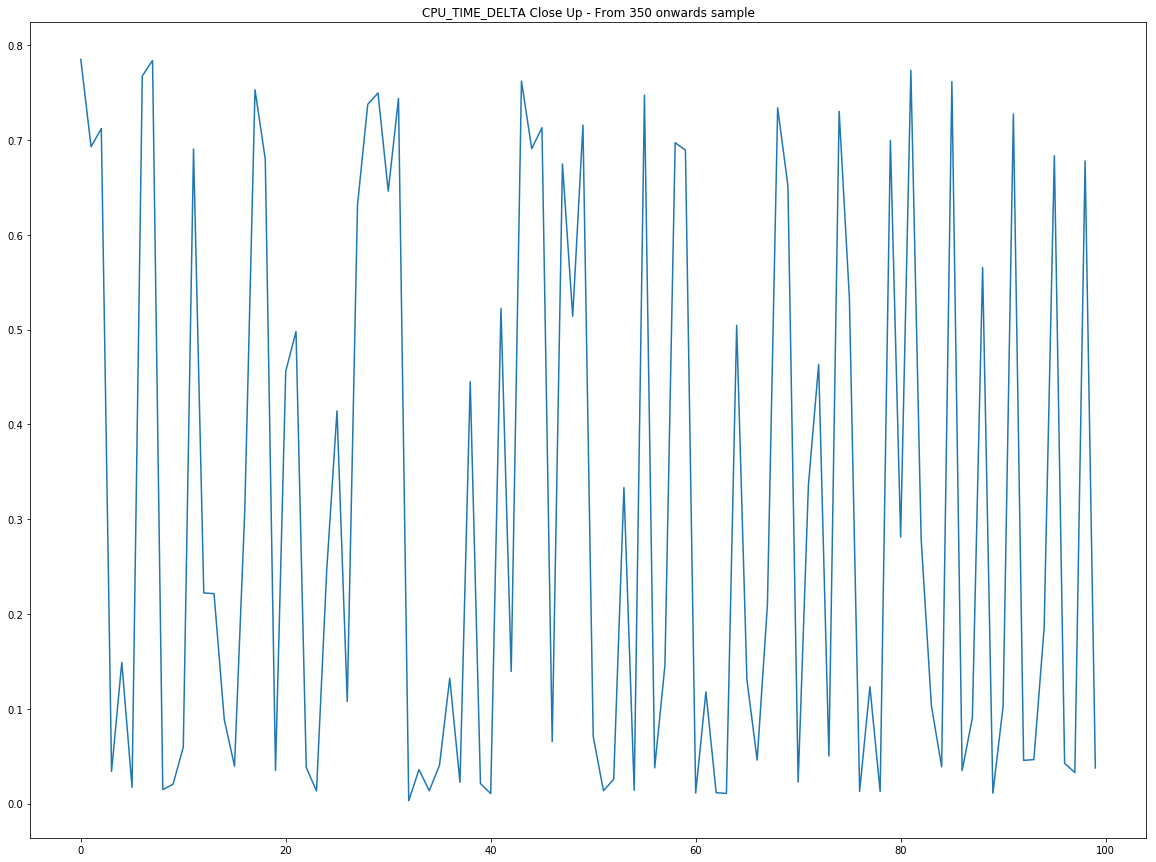

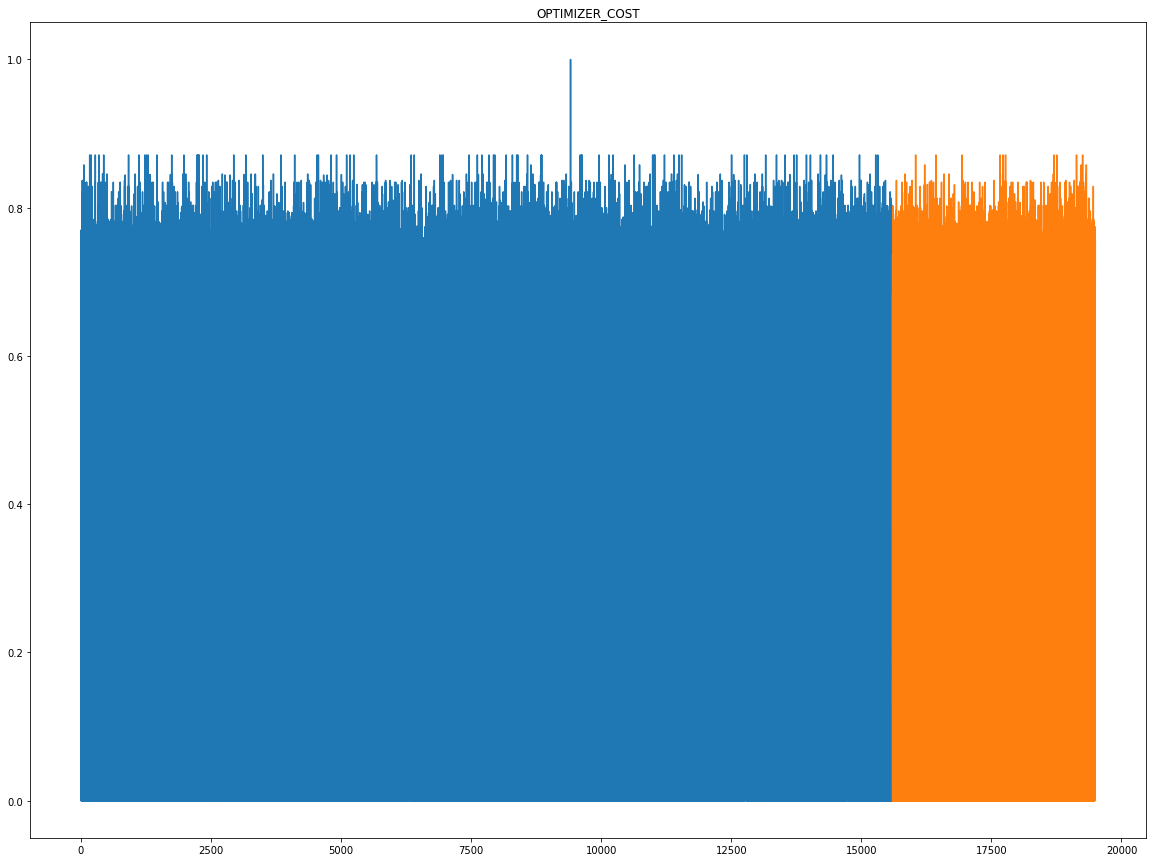

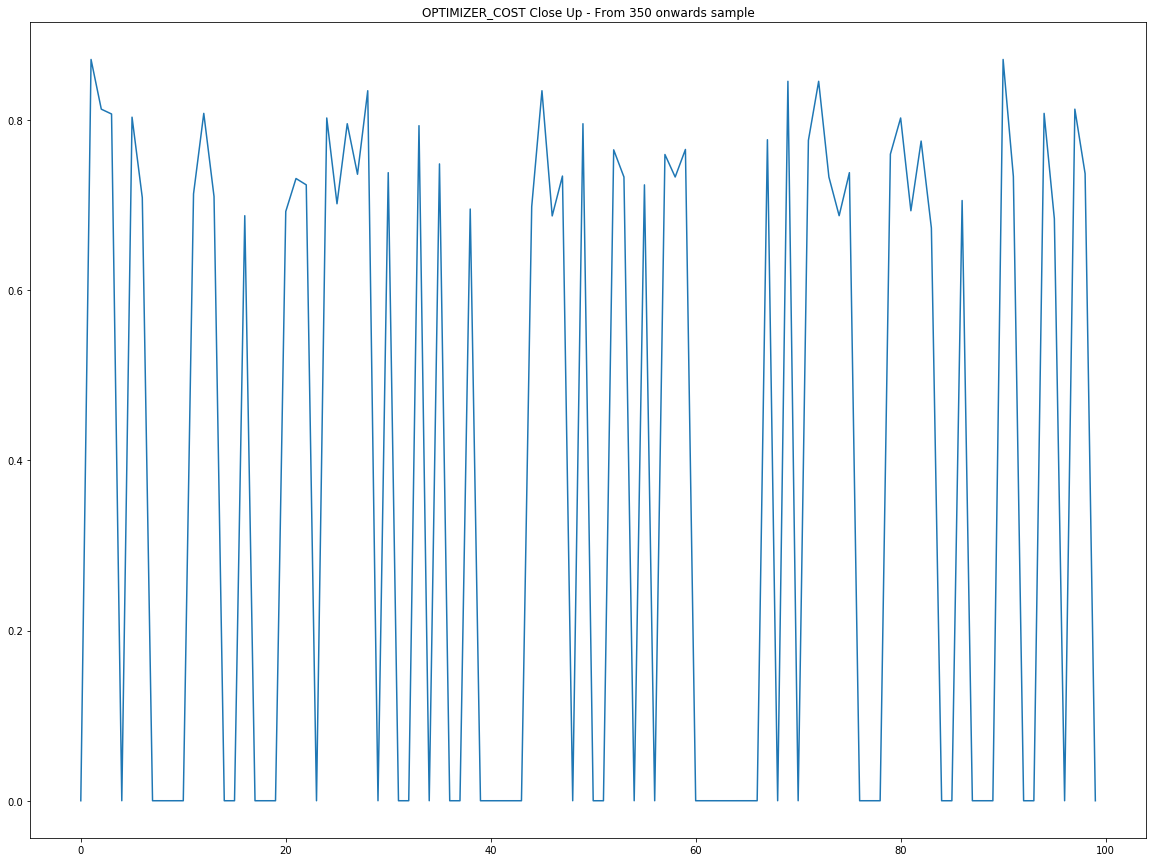

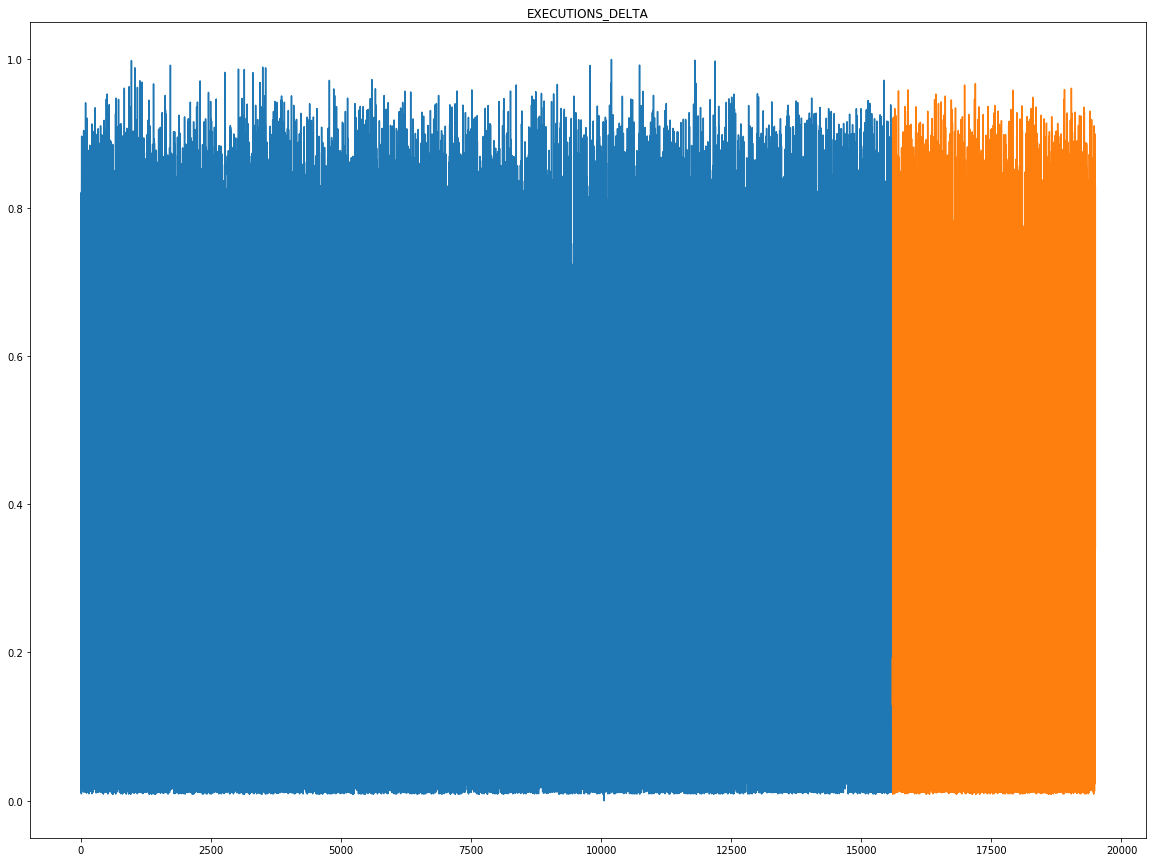

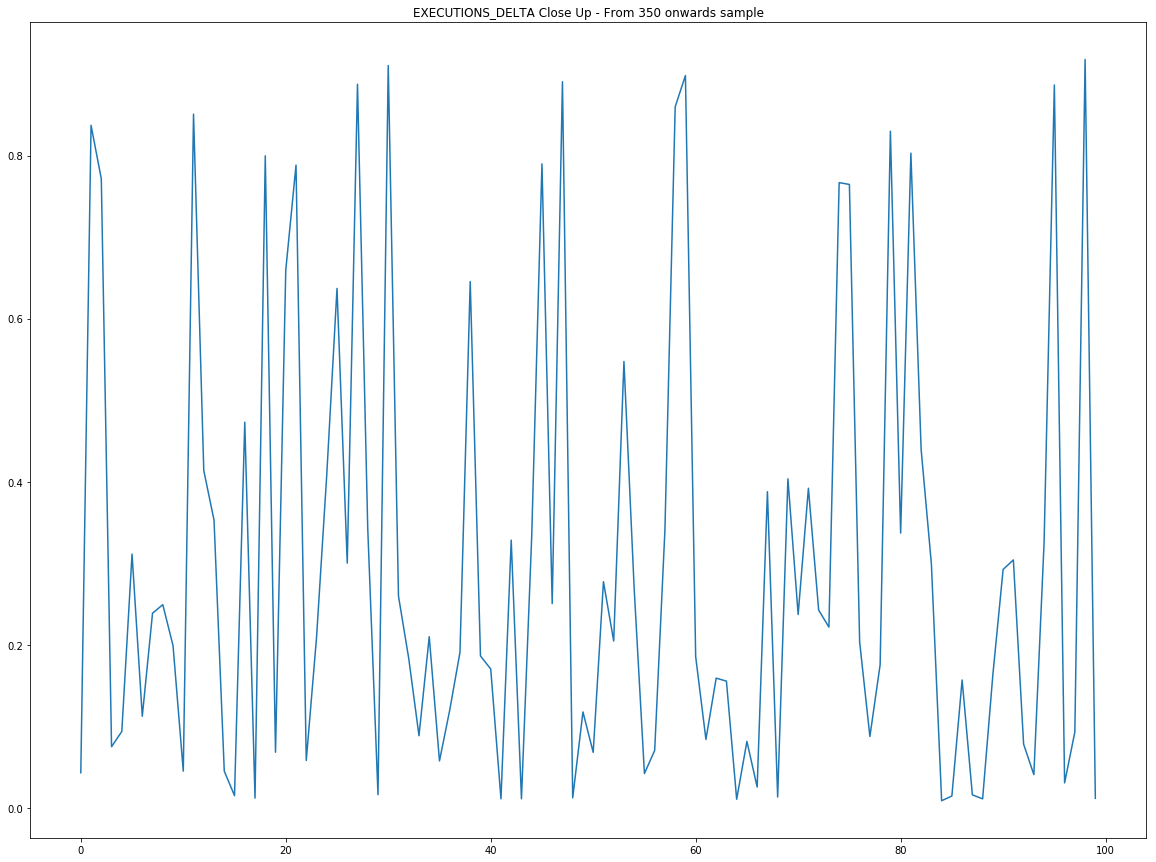

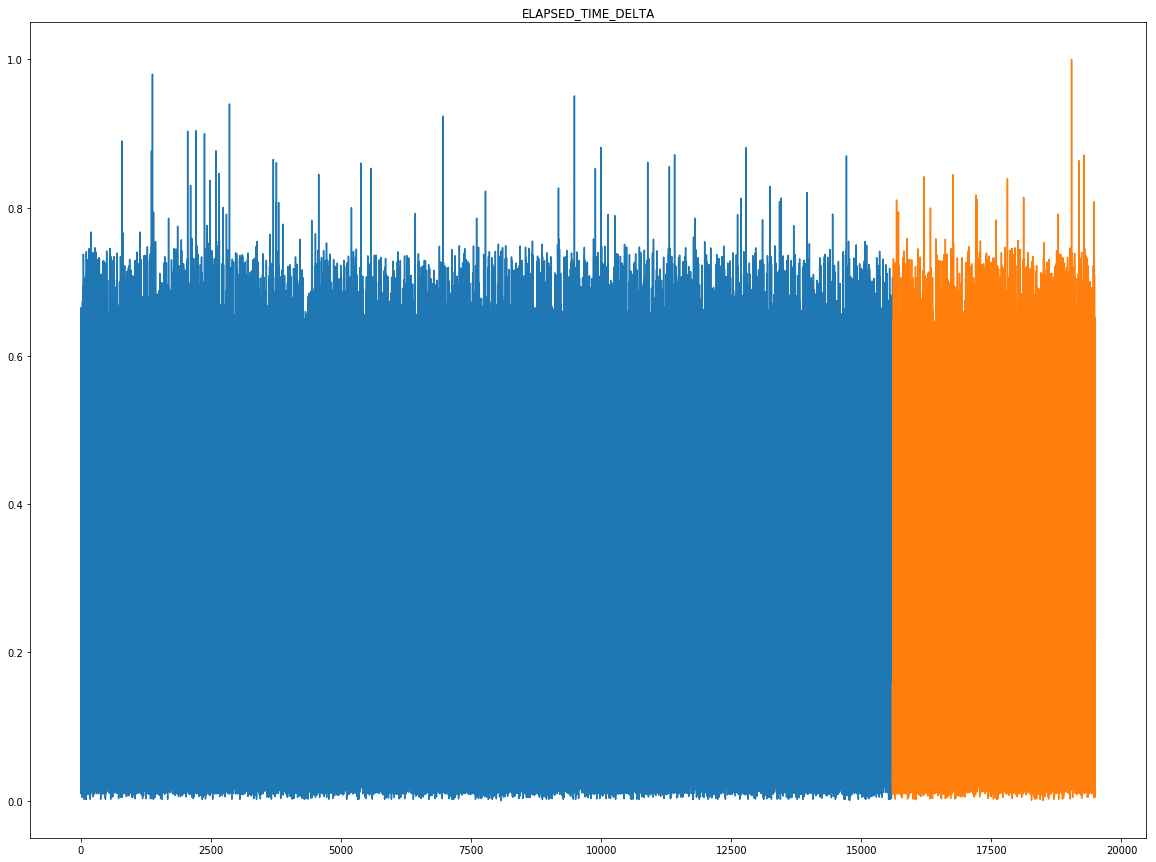

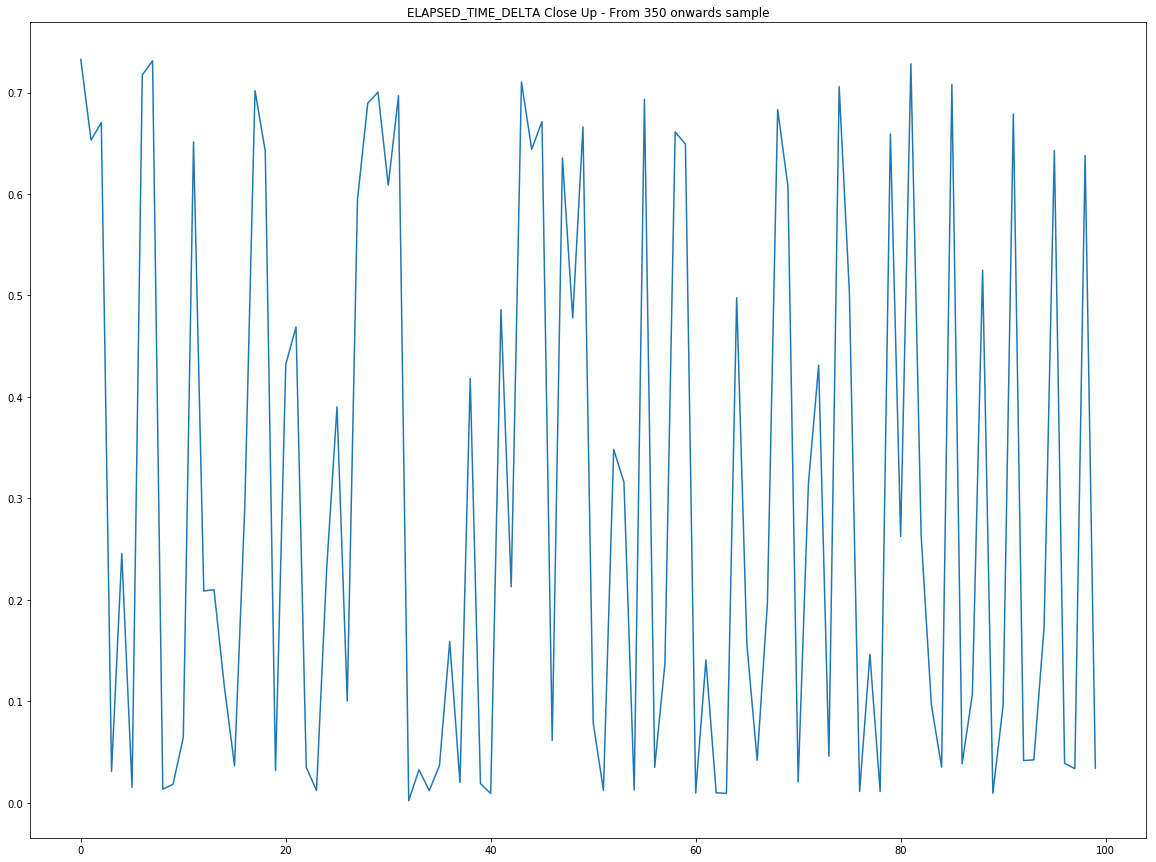

In [50]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))
#
# Plotting label over time for train, test
# print(y_train)
# print(y_train[:,0])
for i in range(0, len(y_validate[0])):
    #
    # Whole Sample
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(y_train[:,i])
    validate_and_test = list(y_validate[:,i]) + list(y_test[:,i])
    plt.plot([None for j in y_train[:,i]] + [x for x in validate_and_test])
    plt.title(y_label[i])
    plt.show()
    #
    # Sub-Sample (100 range)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot([j for j in y_train[sub_sample_start:sub_sample_start+100,i]])
    plt.title(y_label[i] + " Close Up - From " + str(sub_sample_start) + " onwards sample")
    plt.show()

### Random Forest Regression

Random Forests are an improvement over bagged decision trees.

A problem with decision trees like CART is that they are greedy. They choose which variable to split on using a greedy algorithm that minimizes error. As such, even with Bagging, the decision trees can have a lot of structural similarities and in turn have high correlation in their predictions.

Combining predictions from multiple models in ensembles works better if the predictions from the sub-models are uncorrelated or at best weakly correlated.

Random forest changes the algorithm for the way that the sub-trees are learned so that the resulting predictions from all of the subtrees have less correlation.

https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/

In [ ]:
class RandomForest:
    """
    Random Forest Class (Regression + Classification)
    """
    #
    def __init__(self, mode, n_estimators, max_depth=None,parallel_degree=1):
        self.mode = self.__validate(mode)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.parallel_degree=parallel_degree
        if self.mode == 'regression':
            self.model = RandomForestRegressor(max_depth=self.max_depth, 
                                               n_estimators=self.n_estimators,
                                               n_jobs=self.parallel_degree)
        elif self.mode == 'classification':
            self.model = RandomForestClassifier(max_depth=self.max_depth,
                                                n_estimators=self.n_estimators,
                                                n_jobs=self.parallel_degree)
    #
    def __validate(self, mode):
        mode = mode.lower()
        if mode not in ('classification','regression'):
            raise ValueError('Specified mode is incorrect!')
        return mode
    #
    def fit_model(self, X_train, y_train):
        """
        Fits training data to target labels
        """
        self.model.fit(X_train,y_train)
        print(self.model)
    #
    def predict(self, X):
        yhat = self.model.predict(X)
        return yhat
    #
    def predict_and_evaluate(self, X, y, y_labels, plot=False):
        """
        Runs test data through previously trained model, and evaluate differently depending if a regression of classification model
        """
        yhat = self.predict(X)
        if self.mode == 'regression':
            #
            # RMSE Evaluation
            rmse = math.sqrt(mean_squared_error(y, yhat))
            print('Test RFR: %.3f\n-----------------------------\n\n' % rmse)
            #
            # F1-Score Evaluation
            for i in range(len(y_labels)):
                yv_c, yhat_c = [], [] 
                for val in y[:,i]:
                    yv_c.append(discretize_value(amount=val))
                for val in yhat[:,i]:
                    yhat_c.append(discretize_value(amount=val))
                f1 = f1_score(yv_c, yhat_c, average='micro') # Calculate metrics globally by counting the total true positives, false negatives and false positives.
                print('Test FScore [' + y_labels[i] + ']: ' +  str(f1))
            #
        elif self.mode == 'classification':
            #
            # F1-Score Evaluation
            for i in range(len(y_labels)):
                f1 = f1_score(y[:,i], yhat[:,i], average='micro') # Calculate metrics globally by counting the total true positives, false negatives and false positives.
                print('Test FScore [' + y_labels[i] + ']: ' +  str(f1))
        #
        if plot:
            for i in range(0, len(y[0])):
                plt.rcParams['figure.figsize'] = [20, 15]
                plt.plot(y[:,i], label='actual')
                plt.plot(yhat[:,i], label='predicted')
                plt.legend(['actual', 'predicted'], loc='upper left')
                plt.title(y_labels[i])
                plt.show()

In [ ]:
# X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
# X_train = X_train.values
# y_train = y_train.values
# print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
# print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
# #
# X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
# X_validate = X_validate.values
# X_test = X_test.values
# y_validate = y_validate.values
# y_test = y_test.values
# print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
# print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
# print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
# print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))
# #
# model = RandomForest(mode='regression',
#                      n_estimators=n_estimators,
#                      parallel_degree=parallel_degree)
# model.fit_model(X_train=X_train,
#                 y_train=y_train)
# model.predict_and_evaluate(X=X_validate,
#                            y=y_validate,
#                            y_labels=y_label,
#                            plot=True)

### Evaluating the Model (Walk Forward Validation / Testing)

In [ ]:
# model.fit_model(X_train=X_validate,
#                 y_train=y_validate)
# model.predict_and_evaluate(X=X_test,
#                            y=y_test,
#                            y_labels=y_label,
#                            plot=True)

## LSTM Regression
### Designing the network

- The first step is to define your network.
- Neural networks are defined in Keras as a sequence of layers. The container for these layers is the **Sequential class**.
- The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected.
- The LSTM recurrent layer comprised of memory units is called LSTM().
- A fully connected layer that often follows LSTM layers and is used for outputting a prediction is called Dense().
- The first layer in the network must define the number of inputs to expect.
- Input must be three-dimensional, comprised of samples, timesteps, and features.
    - **Samples:** These are the rows in your data.
    - **Timesteps:** These are the past observations for a feature, such as lag variables.
    - **Features:** These are columns in your data.
- Assuming your data is loaded as a NumPy array, you can convert a 2D dataset to a 3D dataset using the reshape() function in NumPy.

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [ ]:
class LSTM:
    """
    Long Short Term Memory Neural Net Class
    """
    #
    def __init__(self, X_train, y_train, layers, mode='regression', optimizer='sgd'):
        """
        Initiating the class creates a net with the established parameters
        :param X_train - Training data used to train the model
        :param y_train - Test data used to test the model
        :param layers - A list of values, where in each value denotes a layer, and the number of neurons for that layer
        :param loss_function - Function used to measure fitting of model (predicted from actual)
        :param optimizer - Function used to optimize the model (eg: Gradient Descent)
        """
        self.mode = mode
        self.model = ke.models.Sequential()
        #
        if len(layers) < 1:
            raise ValueError('Layer Count is Empty!')
        elif len(layers) == 1:
            self.model.add(ke.layers.LSTM(layers[0], input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            for i in range(0,len(layers)-2):
                self.model.add(ke.layers.LSTM(layers[i], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
            self.model.add(ke.layers.LSTM(layers[i]))
        #
        # self.model.add(ke.layers.Dense(y_train.shape[1]))
        self.model.add(ke.layers.Dense(layers[-1]))
        self.model.add(ke.layers.Activation('sigmoid'))
        #
        if self.mode == 'regression':
            self.loss_func = 'mae'
        elif self.mode == 'classification':
            self.loss_func = 'categorical_crossentropy'
        else:
            self.loss_func = None
        #
        if self.mode == 'regression':
            self.model.compile(loss=self.loss_func, optimizer=optimizer)
        elif self.mode == 'classification':
            self.model.compile(loss=self.loss_func, optimizer=optimizer, metrics=['accuracy'])
        #
        # Map Discretize function to matrices
        self.vecfunc = np.vectorize(discretize_value)
        print(self.model.summary())
    #
    def fit_model(self, X_train, X_test, y_train, y_test, epochs=50, batch_size=50, verbose=2, shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.
        """
        history = self.model.fit(x=X_train, 
                                 y=y_train, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 validation_data=(X_test,y_test), 
                                 verbose=verbose, 
                                 shuffle=shuffle)
        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            if self.mode == 'regression':
                plt.plot(history.history['loss'], label='train')
                plt.plot(history.history['val_loss'], label='validation')
            elif self.mode == 'classification':
                plt.plot(history.history['acc'], label='train')
                plt.plot(history.history['val_acc'], label='validation')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()
    #
    def predict(self, X):
        yhat = self.model.predict(X)
        return yhat
    #
    def predict_and_evaluate(self, X, y, y_labels, plot=False):
        yhat = self.predict(X)
        #
        # RMSE Evaluation
        if self.mode == 'regression':
            rmse = math.sqrt(mean_squared_error(y, yhat))
            print('Test ' + self.loss_func + ': %.3f\n-----------------------------\n\n' % rmse)
            #
            # F1-Score Evaluation
            for i in range(len(y_labels)):
                yv_c, yhat_c = [], [] 
                for val in y[:,i]:
                    yv_c.append(discretize_value(amount=val))
                for val in yhat[:,i]:
                    yhat_c.append(discretize_value(amount=val))
                f1 = f1_score(yv_c, yhat_c, average='micro') # Calculate metrics globally by counting the total true positives, false negatives and false positives.
                print('Test FScore [' + y_labels[i] + ']: ' +  str(f1))
        elif self.mode == 'classification':
            yhat=self.vecfunc(yhat)
            #
            # F1-Score Evaluation
            for i in range(len(y_labels)):
                f1 = f1_score(y[:,i], yhat[:,i], average='micro') # Calculate metrics globally by counting the total true positives, false negatives and false positives.
                print('Test FScore [' + y_labels[i] + ']: ' +  str(f1))
        #
        if plot:
            for i in range(0, len(y[0])):
                plt.rcParams['figure.figsize'] = [20, 15]
                plt.plot(y[:,i], label='actual')
                plt.plot(yhat[:,i], label='predicted')
                plt.legend(['actual', 'predicted'], loc='upper left')
                plt.title(y_labels[i])
                plt.show()
                

The type of predictive modeling problem imposes constraints on the type of loss function that can be used.

Below is a list of the metrics that you can use in Keras on regression problems.
* Mean Squared Error: mean_squared_error, MSE or mse
* Mean Absolute Error: mean_absolute_error, MAE, mae
* Mean Absolute Percentage Error: mean_absolute_percentage_error, MAPE, mape
* Cosine Proximity: cosine_proximity, cosine

The most common optimization algorithm is stochastic gradient descent, but Keras also supports a suite of other state-of-the-art optimization algorithms that work well with little or no configuration.

Perhaps the most commonly used optimization algorithms because of their generally better performance are:

* Stochastic Gradient Descent, or ‘sgd‘, that requires the tuning of a learning rate and momentum.
* ADAM, or ‘adam‘, that requires the tuning of learning rate.
* RMSprop, or ‘rmsprop‘, that requires the tuning of learning rate.

More here: https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/


X_train shape [(15599, 520)] Type - <class 'numpy.ndarray'>
y_train shape [(15599, 4)] Type - <class 'numpy.ndarray'>
X_validate shape [(1950, 520)] Type - <class 'numpy.ndarray'>
y_validate shape [(1950, 4)] Type - <class 'numpy.ndarray'>
X_test shape [(1950, 520)] Type - <class 'numpy.ndarray'>
y_test shape [(1950, 4)] Type - <class 'numpy.ndarray'>

Reshaping Training Frames
X_train shape [(15599, 1, 520)] Type - <class 'numpy.ndarray'>
X_validate shape [(1950, 1, 520)] Type - <class 'numpy.ndarray'>
X_test shape [(1950, 1, 520)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 520)            2165280   
_________________________________________________________________
lstm_6 (LSTM)                (None, 520)               2165280   
_________________________________________________________________
dense_3 (Dense)              (None

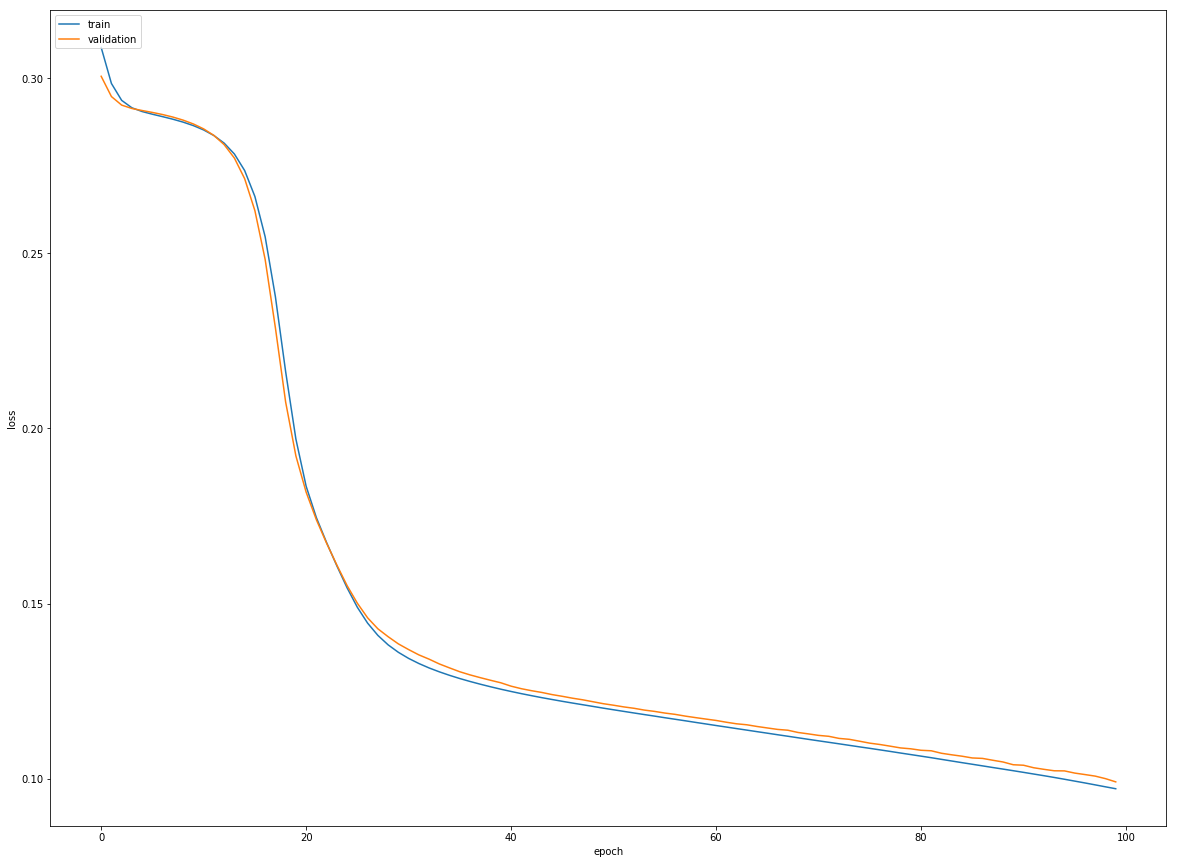

Test mae: 0.182
-----------------------------


Test FScore [CPU_TIME_DELTA]: 0.6148717948717949
Test FScore [OPTIMIZER_COST]: 0.20153846153846153
Test FScore [EXECUTIONS_DELTA]: 0.4338461538461538
Test FScore [ELAPSED_TIME_DELTA]: 0.6287179487179487


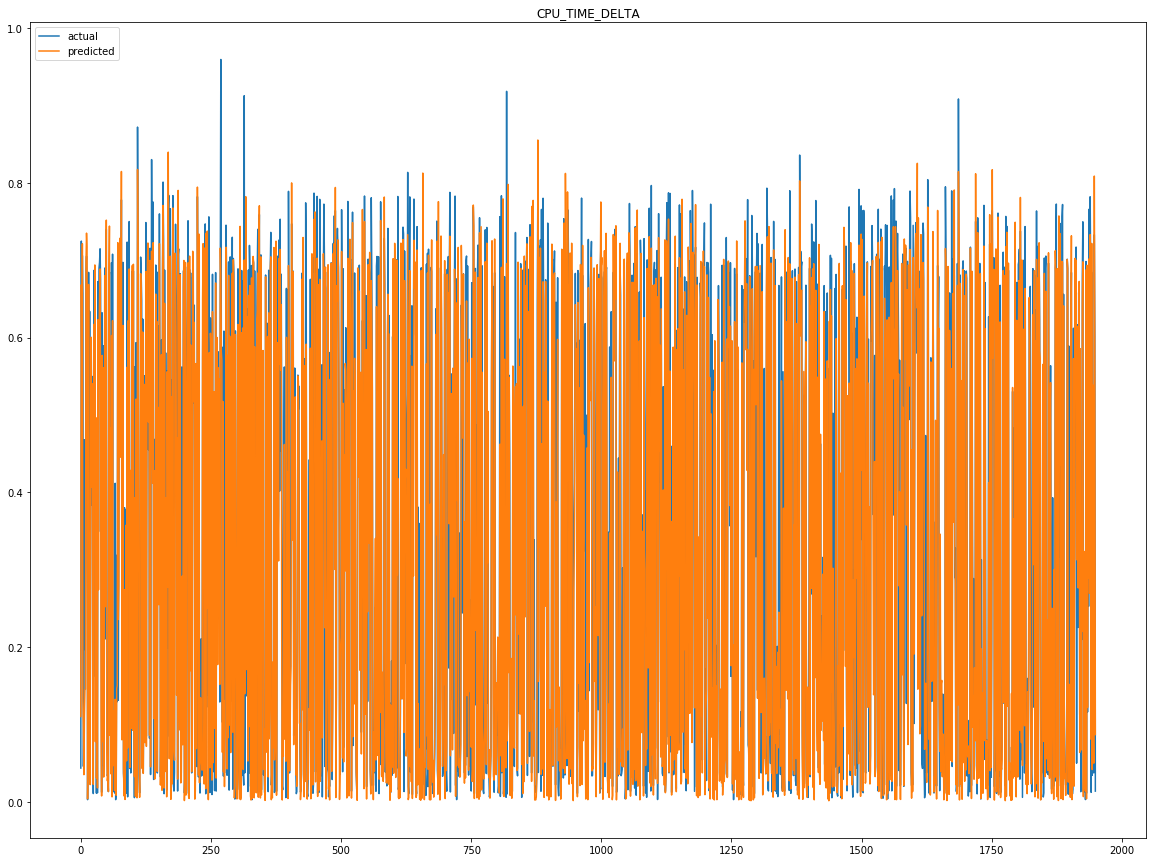

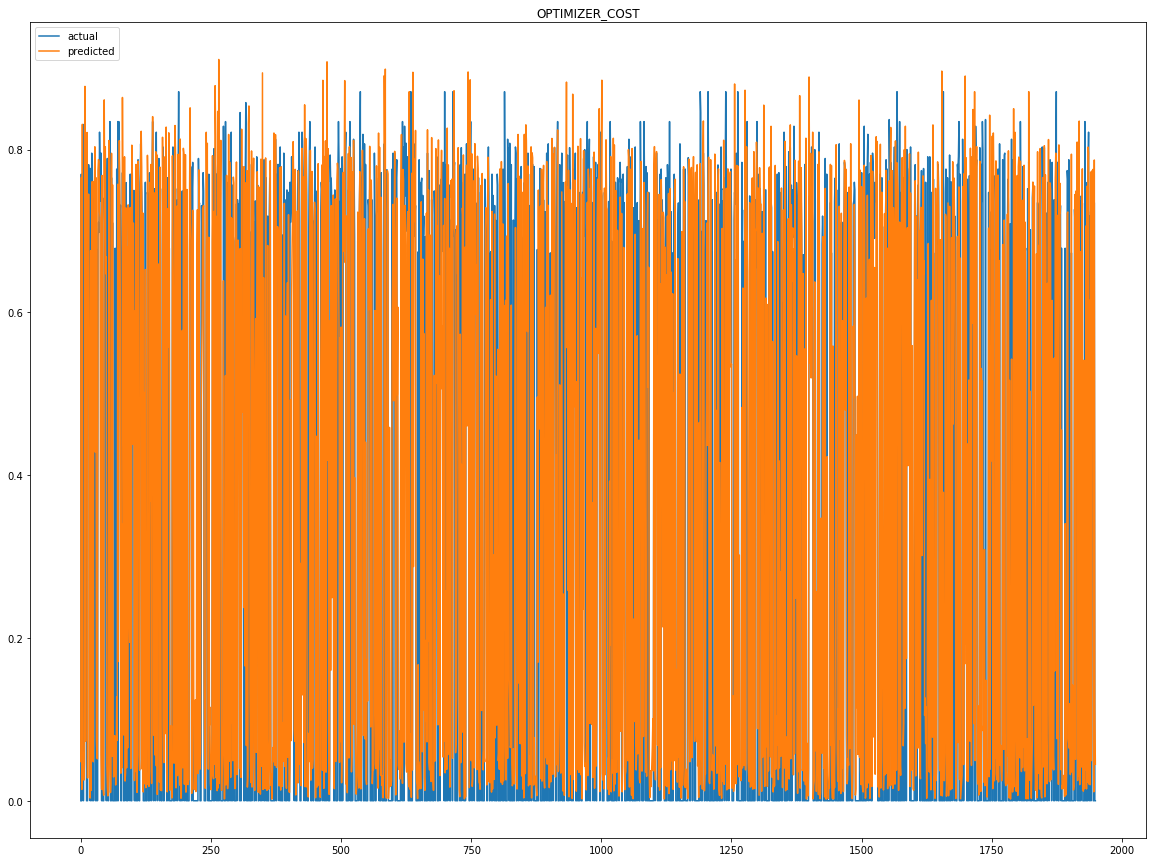

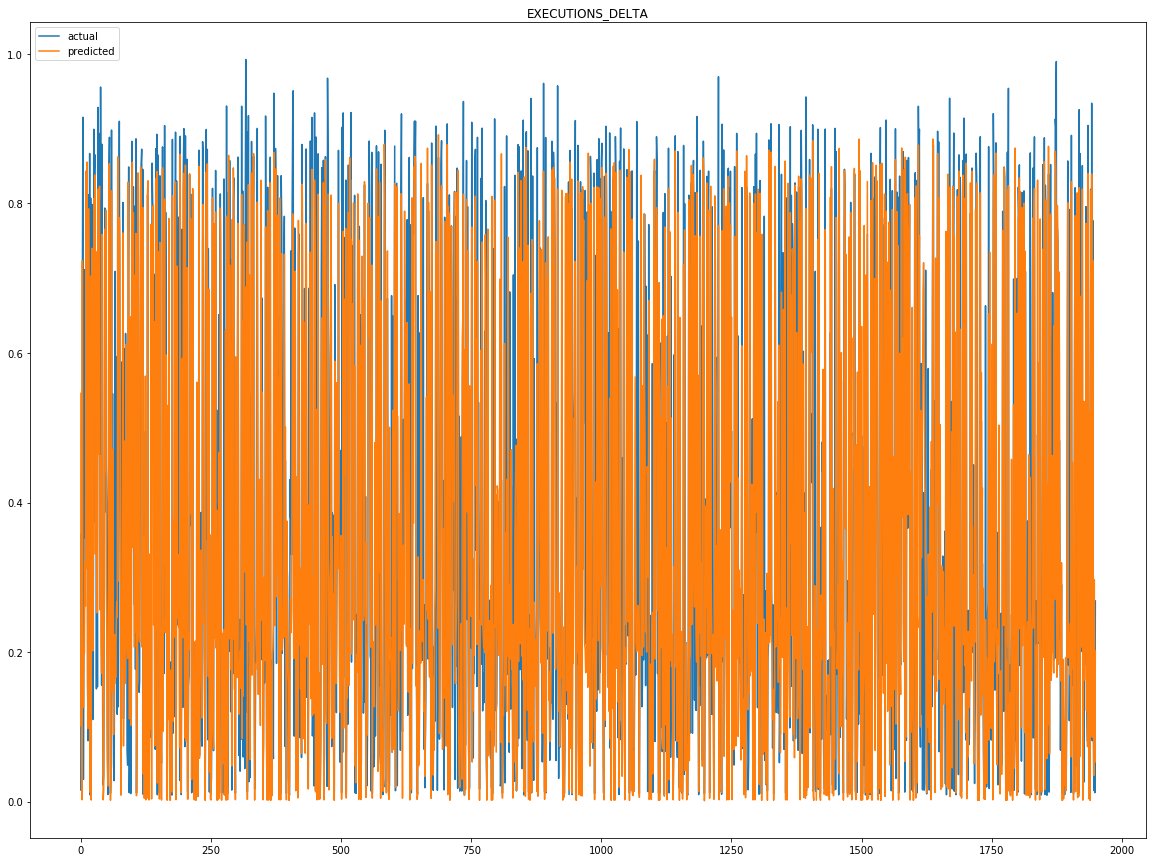

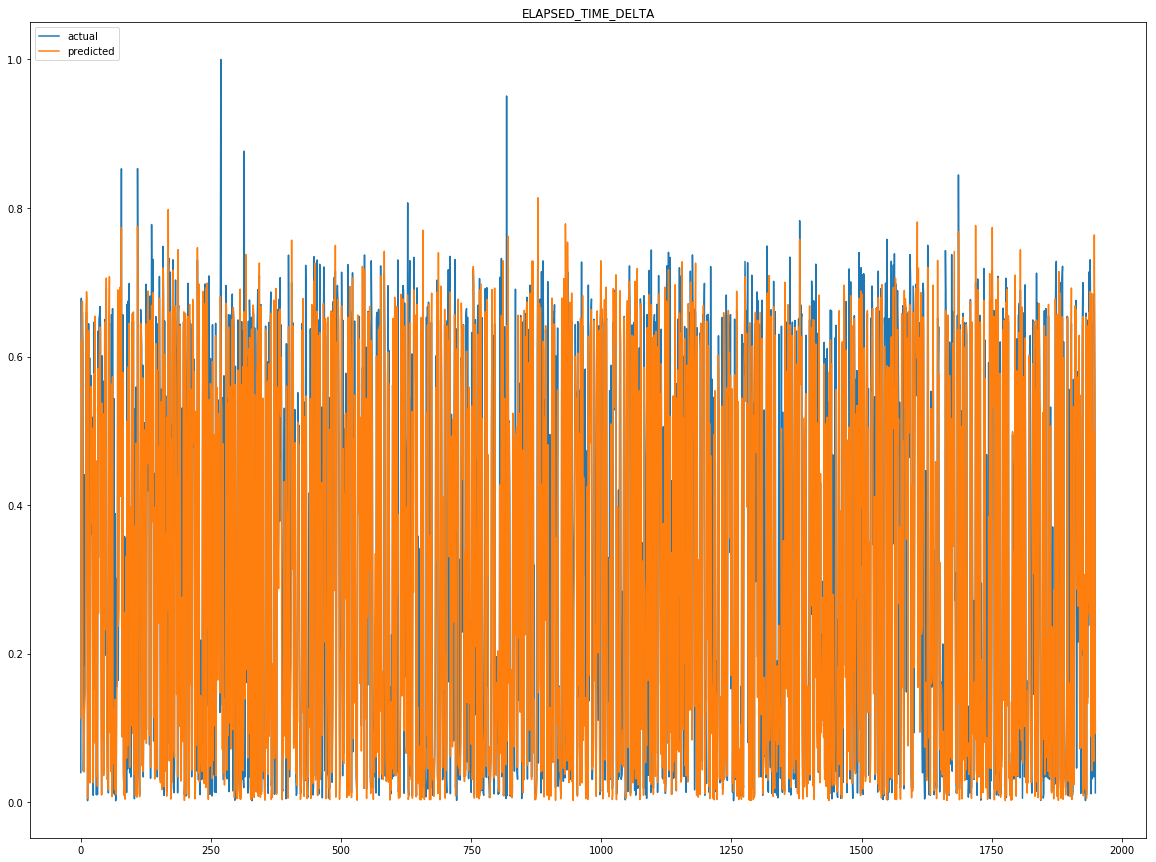

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))
#
# Reshape for fitting in LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validate = X_validate.reshape((X_validate.shape[0], 1, X_validate.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
#    
model = LSTM(X_train=X_train,
             y_train=y_train,
             layers=[X_train.shape[2],
                     int(X_train.shape[2]),
                     len(y_label)],
             mode='regression')
model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=100, 
                batch_size=batch_size,
                verbose=2, 
                shuffle=False,
                plot=True)
model.predict_and_evaluate(X=X_validate,
                           y=y_validate,
                           y_labels=y_label,
                           plot=True)

### Evaluating the Model (Walk Forward Validation / Testing)

* https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/
* https://machinelearningmastery.com/instability-online-learning-stateful-lstm-time-series-forecasting/

In [ ]:
model.fit_model(X_train=X_validate,
                X_test=X_test,
                y_train=y_validate,
                y_test=y_test,
                epochs=100, 
                batch_size=1, # Incremental batch size fitting
                verbose=2, 
                shuffle=False,
                plot=True)
model.predict_and_evaluate(X=X_test,
                           y=y_test,
                           y_labels=y_label,
                           plot=True)

Train on 1950 samples, validate on 1950 samples
Epoch 1/100
 - 209s - loss: 0.1073 - val_loss: 0.1036
Epoch 2/100
 - 208s - loss: 0.1061 - val_loss: 0.0999
Epoch 3/100
 - 208s - loss: 0.1048 - val_loss: 0.0983
Epoch 4/100
 - 209s - loss: 0.1042 - val_loss: 0.1007
Epoch 5/100
 - 208s - loss: 0.1037 - val_loss: 0.1032
Epoch 6/100
 - 209s - loss: 0.1022 - val_loss: 0.0982
Epoch 7/100
 - 208s - loss: 0.1022 - val_loss: 0.0969
Epoch 8/100
 - 209s - loss: 0.1011 - val_loss: 0.0970
Epoch 9/100
 - 208s - loss: 0.1002 - val_loss: 0.0980
Epoch 10/100
 - 208s - loss: 0.0997 - val_loss: 0.1034
Epoch 11/100
 - 210s - loss: 0.0995 - val_loss: 0.0977
Epoch 12/100
 - 207s - loss: 0.0988 - val_loss: 0.0966
Epoch 13/100
 - 209s - loss: 0.0985 - val_loss: 0.0990
Epoch 14/100
 - 209s - loss: 0.0981 - val_loss: 0.0955
Epoch 15/100
 - 209s - loss: 0.0976 - val_loss: 0.0974
Epoch 16/100
 - 208s - loss: 0.0971 - val_loss: 0.0977
Epoch 17/100
 - 208s - loss: 0.0969 - val_loss: 0.0972
Epoch 18/100
 - 208s - los

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

* 0  - 10
* 11 - 20
* 21 - 30
* 31 - 40
* 41 - 50
* 51 - 60
* 61 - 70
* 71 - 80
* 81 - 90
* 91 - 100

Classify Features X into buckets of 10 (1-100% : intervals of 10%), in the attempts to convert this regression problem into one of classification.

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

### RandomForest Classification

In [ ]:
# X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
# X_train = X_train.values
# y_train = y_train.values
# print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
# print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
# #
# X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
# X_validate = X_validate.values
# X_test = X_test.values
# y_validate = y_validate.values
# y_test = y_test.values
# print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
# print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
# print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
# print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)) + "\n------------------------------")
# #
# # Map Discretize function to matrices
# vecfunc = np.vectorize(discretize_value)
# print(X_train)
# print(y_train)
# X_train=vecfunc(X_train)
# y_train=vecfunc(y_train)
# print(X_train)
# print(y_train)
# print('------------------------------------------------------------')
# print(X_validate)
# print(y_validate)
# X_validate=vecfunc(X_validate)
# y_validate=vecfunc(y_validate)
# print(X_validate)
# print(y_validate)
# print('------------------------------------------------------------')
# print(X_test)
# print(y_test)
# X_test=vecfunc(X_test)
# y_test=vecfunc(y_test)
# print(X_test)
# print(y_test)
# #
# # Train on discrete data (Train > Validation)
# model = RandomForest(mode='classification',
#                      n_estimators=n_estimators,
#                      parallel_degree=parallel_degree)
# model.fit_model(X_train=X_train,
#                 y_train=y_train)
# model.predict_and_evaluate(X=X_validate,
#                            y=y_validate,
#                            y_labels=y_label,
#                            plot=True)
# #
# # Train on discrete data (Train + Validation > Test)
# model.fit_model(X_train=X_validate,
#                 y_train=y_validate)
# model.predict_and_evaluate(X=X_test,
#                            y=y_test,
#                            y_labels=y_label,
#                            plot=True)

### LSTM Classification

Below is a list of the metrics that you can use in Keras on classification problems.

* Binary Accuracy: binary_accuracy, acc
* Categorical Accuracy: categorical_accuracy, acc
* Sparse Categorical Accuracy: sparse_categorical_accuracy
* Top k Categorical Accuracy: top_k_categorical_accuracy (requires you specify a k parameter)
* Sparse Top k Categorical Accuracy: sparse_top_k_categorical_accuracy (requires you specify a k parameter)

--------------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)) + "\n------------------------------")
#
# Map Discretize function to matrices
vecfunc = np.vectorize(discretize_value)
print(X_train)
print(y_train)
X_train=vecfunc(X_train)
y_train=vecfunc(y_train)
print(X_train)
print(y_train)
print('------------------------------------------------------------')
print(X_validate)
print(y_validate)
X_validate=vecfunc(X_validate)
y_validate=vecfunc(y_validate)
print(X_validate)
print(y_validate)
print('------------------------------------------------------------')
print(X_test)
print(y_test)
X_test=vecfunc(X_test)
y_test=vecfunc(y_test)
print(X_test)
print(y_test)
#
# Reshape for fitting in LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validate = X_validate.reshape((X_validate.shape[0], 1, X_validate.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
#
# Train on discrete data (Train > Validation)
discrete_model = LSTM(X_train=X_train,
                      y_train=y_train,
                      layers=[X_train.shape[2],
                              int(X_train.shape[2]),
                              len(y_label)],
                      mode='classification')
discrete_model.fit_model(X_train=X_train,
                         X_test=X_validate,
                         y_train=y_train,
                         y_test=y_validate,
                         epochs=25, 
                         batch_size=batch_size,
                         verbose=2, 
                         shuffle=False,
                         plot=True)
discrete_model.predict_and_evaluate(X=X_validate,
                                    y=y_validate,
                                    y_labels=y_label,
                                    plot=True)
#
# Train on discrete data (Train + Validation > Test)
discrete_model.fit_model(X_train=X_validate,
                         X_test=X_test,
                         y_train=y_validate,
                         y_test=y_test,
                         epochs=10, 
                         batch_size=1, # Incremental batch size fitting
                         verbose=2, 
                         shuffle=False,
                         plot=True)
discrete_model.predict_and_evaluate(X=X_test,
                                    y=y_test,
                                    y_labels=y_label,
                                    plot=True)